In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from numpy import random as r

from pylab import *
from IPython.core.pylabtools import figsize

import seaborn as sns
import matplotlib.cm as cm

import sys
sys.path.insert(0, '../../utils')
import splicing_utils as spu
import single_cell_plots as scp
from single_cell_plots import *

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt

mpl.rcParams["mathtext.fontset"] = "stix"

In [2]:
import importlib
importlib.reload(scp)

<module 'single_cell_plots' from '../../utils/single_cell_plots.py'>

In [3]:
def process_symsim(table_name, n=500, g=1500):
    
    '''
    input:
    * table_name (str): path to the table with isoform counts. 
      Should have a (2g,n) dimension.
    * n (int): number of cells in the simulation (columns)
    * g (int): number of genes in the simulation. Isoforms are 2g.
    
    output:
    * counts (df): dataframe (g,n) with the total mRNA or read counts 
      for each gene (sum of included and excluded counts).
    * psi (df): dataframe (g,n) with ratio of included / total counts. NA
      for cases where total counts == 0.
      
    Description:    
      Get the ratio of isoform read or mRNA counts from SymSim output.
      No splicing junction downsampling.
    
      Assumes that the original table's shape is (n, 2g). The first 
      g rows correspond to the "included" isoforms. The latter g rows
      correspond to the "excluded" isoform (order is preserved).
    
      Originally used for reads before I realized the bias SymSim introduces 
      when gene length is set as constant.
    
      Useful for getting the true PSI of ASE.
    '''
    
    # read table
    tabla = pd.read_csv(table_name, sep='\t', names = ['cell_' + str(i) for i in range(1, n+1)])
    
    # select counts for each isoform
    i = tabla.iloc[:g]
    e = tabla.iloc[g:].reset_index(drop=True)
    
    # calculate total counts and PSI
    counts = i + e
    psi = i/counts
    
    return counts, psi

def process_symsim3(table_name, gene_len, n=500, g=1500, read_len=50):
    
    gene_len_i = gene_len[:g]
    gene_len_e = gene_len[g:]
    
    biases_i = (4*(read_len-1))/gene_len_i
    biases_e = (2*(read_len-1))/gene_len_e
    
    tabla = pd.read_csv(table_name, sep='\t', names = ['cell_' + str(i) for i in range(1, n+1)])
    
    i = tabla.iloc[:g]
    e = tabla.iloc[g:].reset_index(drop=True)
    
    cuentas_i = pd.DataFrame(np.array([r.binomial(i.loc[x], biases_i[x]) for x in i.index]))
    cuentas_e = pd.DataFrame(np.array([r.binomial(e.loc[x], biases_e[x]) for x in e.index]))

    counts = cuentas_i + 2*cuentas_e
    psi = cuentas_i/counts
    
    return counts, psi#, i, e

In [4]:
def plot_heatmap(hm_matrix, title, xlabel, ylabel, cmap, vmin, vmax, cbar_label, plot_name):
    fig = plt.figure(figsize=(12,9))

    figure_title = title
    ax  = plt.subplot(1,1,1)

    plt.text(0.5, 1.03, figure_title,
             horizontalalignment='center',
             fontsize=28,
             transform = ax.transAxes)
    
    ax = sns.heatmap(hm_matrix, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws={'label': cbar_label})
    ax.figure.axes[-1].yaxis.label.set_size(20)


    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)

#     plt.savefig(plot_name + '.svg')
#     plt.savefig(plot_name + '.pdf')
#     plt.savefig(plot_name + '.png')

In [3]:
gene_len = np.array([int(x.rstrip()) for x in open('sim7/gene_length.txt').readlines()])

uni_true_counts, uni_true_psi = process_symsim('sim7/unimodal_true.tab')
uni_1_counts, uni_1_psi = process_symsim3('sim7/unimodal_observed_1.tab', gene_len)
uni_05_counts, uni_05_psi = process_symsim3('sim7/unimodal_observed_05.tab', gene_len)
uni_02_counts, uni_02_psi = process_symsim3('sim7/unimodal_observed_02.tab', gene_len)
uni_01_counts, uni_01_psi = process_symsim3('sim7/unimodal_observed_01.tab', gene_len)

NameError: name 'process_symsim' is not defined

In [6]:
sort_uni_expression = uni_true_counts.mean(axis=1).sort_values().index
bins_uni_true = scp.get_bins_table(uni_true_psi, uni_true_counts)
bins_uni_1 = scp.get_bins_table(uni_1_psi, uni_true_counts)
bins_uni_05 = scp.get_bins_table(uni_05_psi, uni_true_counts)
bins_uni_02 = scp.get_bins_table(uni_02_psi, uni_true_counts)
bins_uni_01 = scp.get_bins_table(uni_01_psi, uni_true_counts)

/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


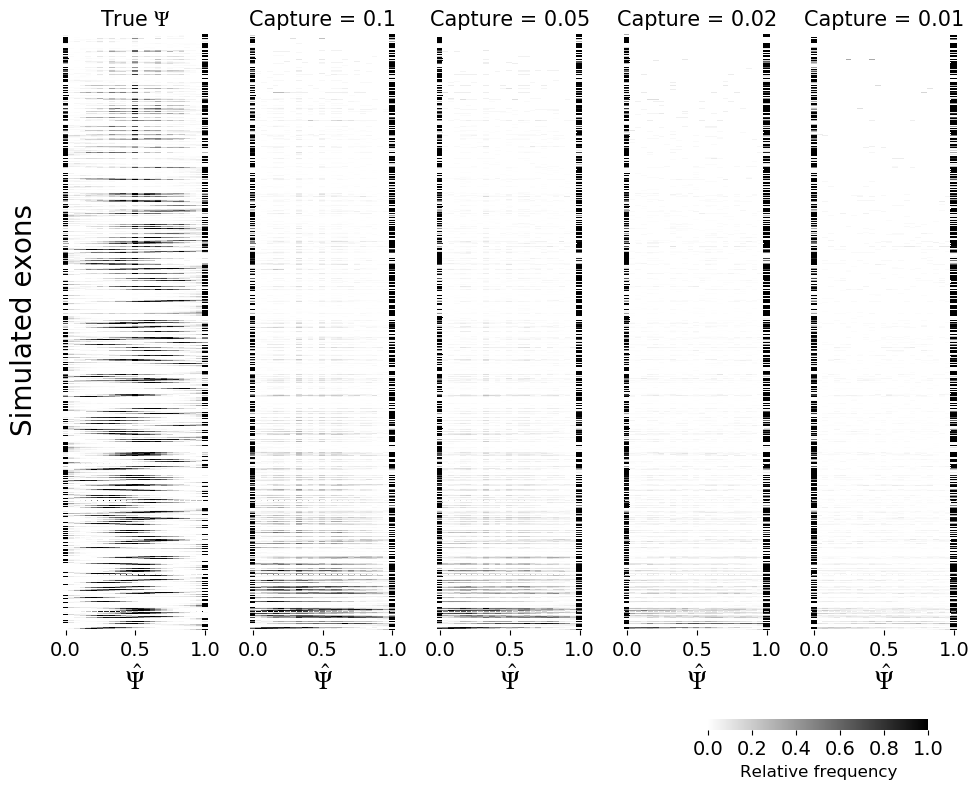

In [7]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
hist_list = [bins_uni_true[0], bins_uni_1[0], bins_uni_05[0], bins_uni_02[0], bins_uni_01[0]]
dset_name_list = ["True $\Psi$", "Capture = 0.1", "Capture = 0.05", "Capture = 0.02", "Capture = 0.01"]

scp.plot_histograms(hist_list, dset_name_list, fig_len=10, fig_height = 10, ypos1=0.025, ypos2 = 0.625,
                    plot_dir = 'plots/sim7/', plot_name = 'sim7_unimodal',
                    plot_title = "", 
                    ylab='Simulated exons', ls=12, sk=1.65, tfs=14, name_size=15)

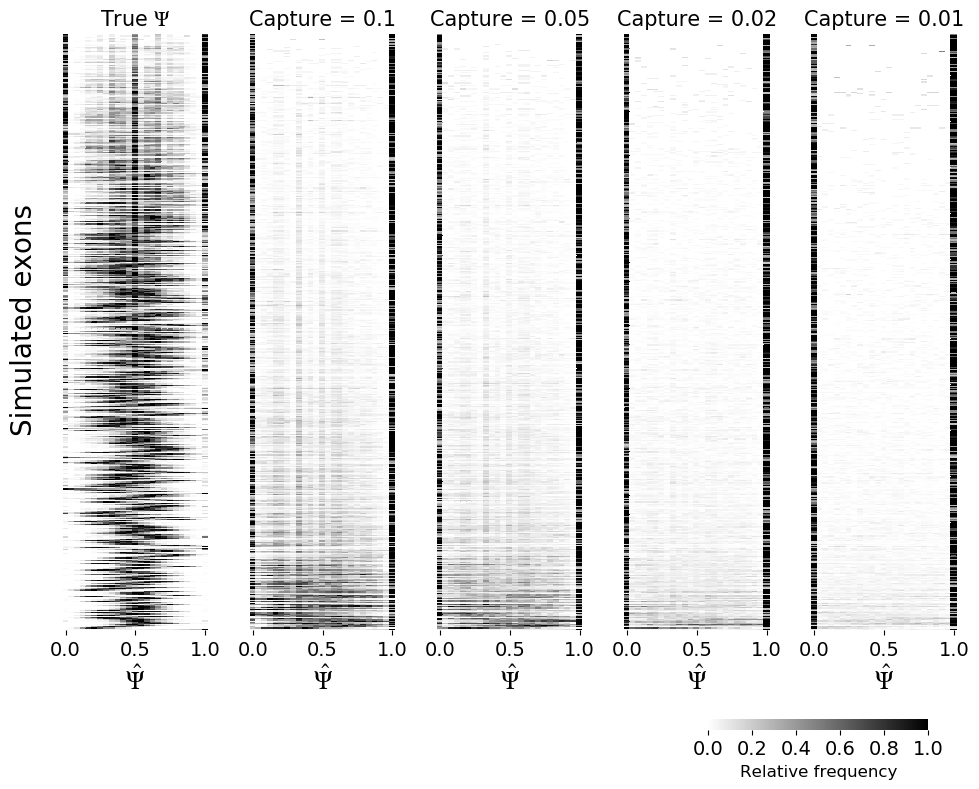

In [8]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
hist_list = [bins_uni_true[1], bins_uni_1[1], bins_uni_05[1], bins_uni_02[1], bins_uni_01[1]]
dset_name_list = ["True $\Psi$", "Capture = 0.1", "Capture = 0.05", "Capture = 0.02", "Capture = 0.01"]

scp.plot_histograms(hist_list, dset_name_list, fig_len=10, fig_height = 10, ypos1=0.025, ypos2 = 0.625,
                    plot_dir = 'plots/sim7/', plot_name = 'sim7_unimodal_intermediate',
                    plot_title = "", 
                    ylab='Simulated exons', ls=12, sk=1.65, tfs=14, name_size=15)

-0.8384302622487206

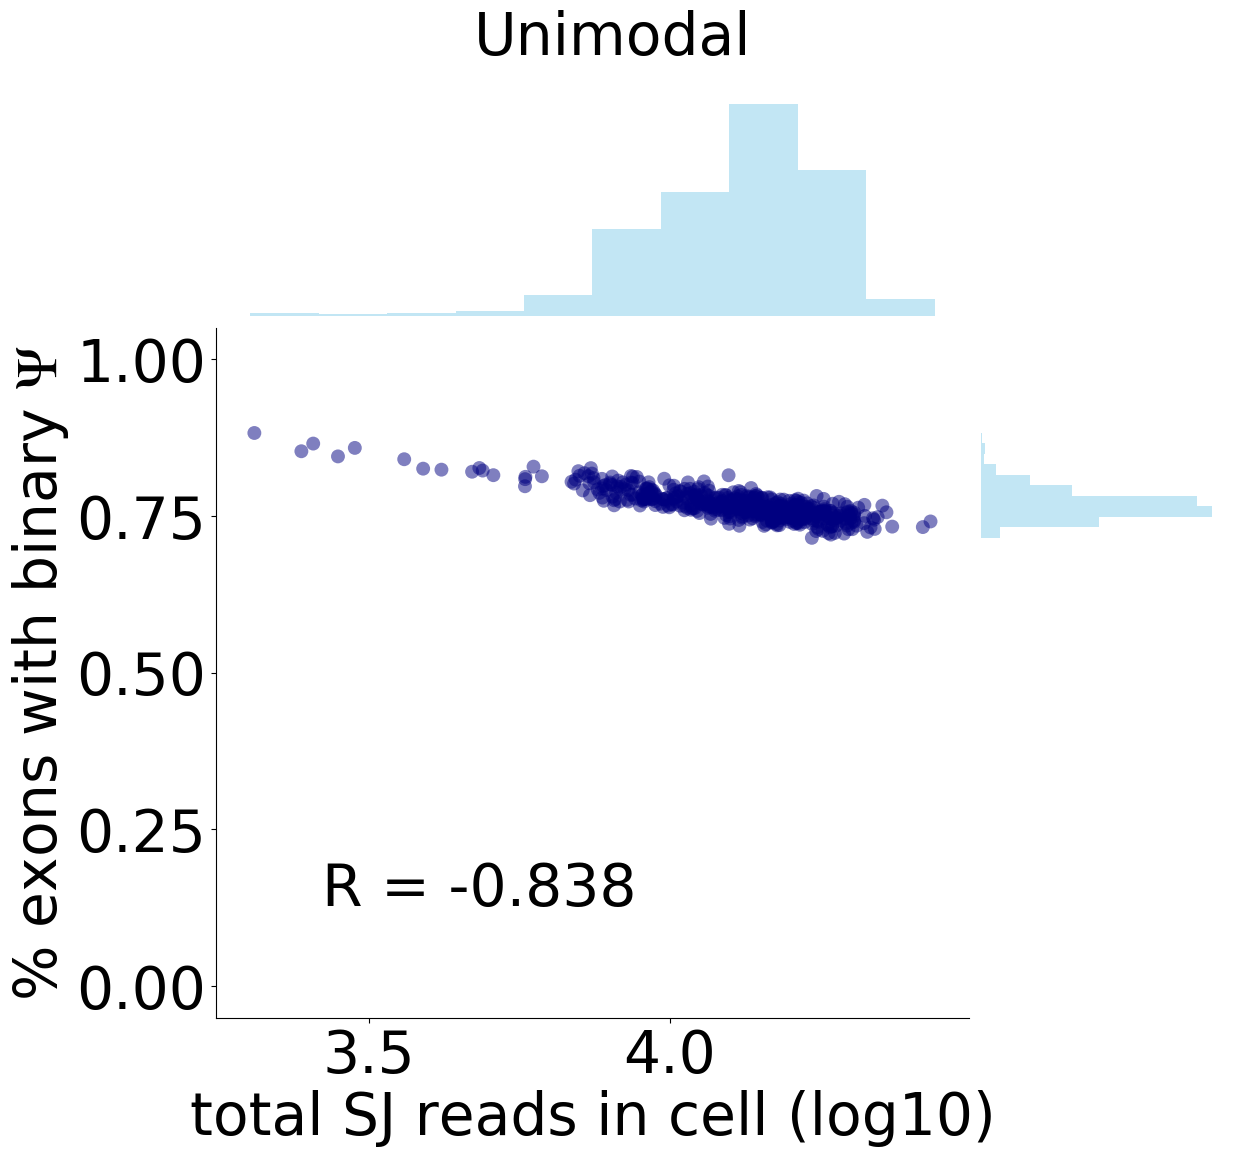

In [15]:
import importlib
importlib.reload(scp)

figsize(13,12)
scp.plot_cell_expression_v_binary(uni_1_psi, uni_1_counts, 'Unimodal', 'simulated_unimodal_data', 

                                  plot_dir = 'plots/sim7/', just_show=False)


-0.8283519677180797

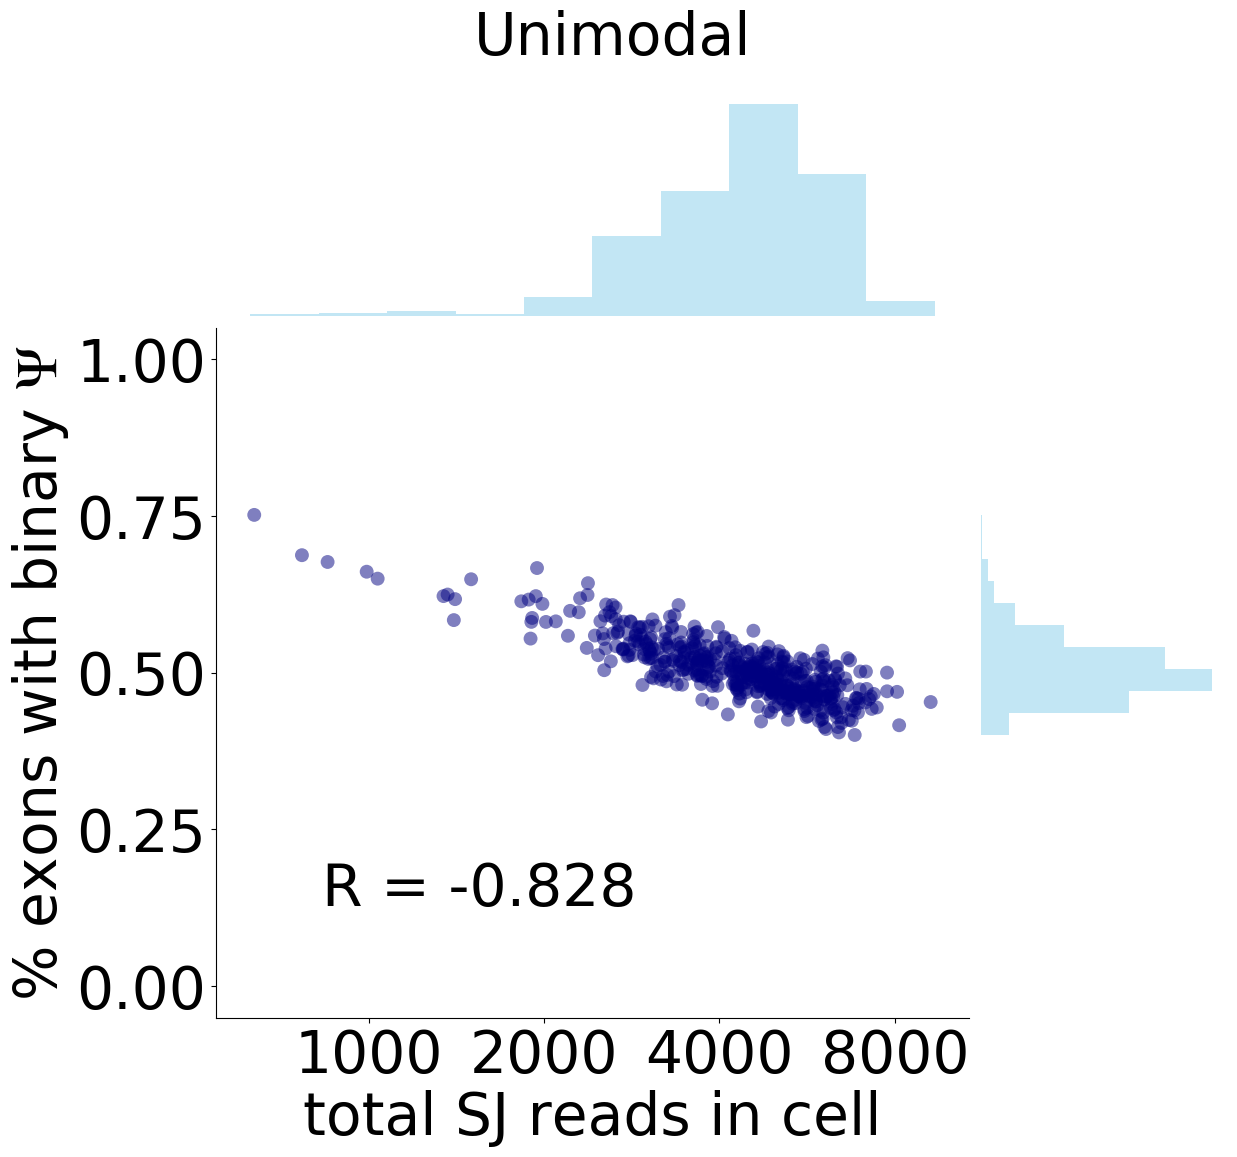

In [28]:
import importlib
importlib.reload(scp)

inter = uni_1_psi.loc[(uni_1_psi.mean(axis=1) >= 0.2) & (uni_1_psi.mean(axis=1) <= 0.8)].index

xlocations = [1000, 2000, 4000, 8000,]
scp.plot_cell_expression_v_binary(uni_1_psi.loc[inter], uni_1_counts.loc[inter], 'Unimodal', 
                                  'simulated_unimodal_data_intermediate',
                                  xlocations = xlocations, xlabel='total SJ reads in cell',
                                   
                              plot_dir = 'plots/sim7/', just_show=False)

nan

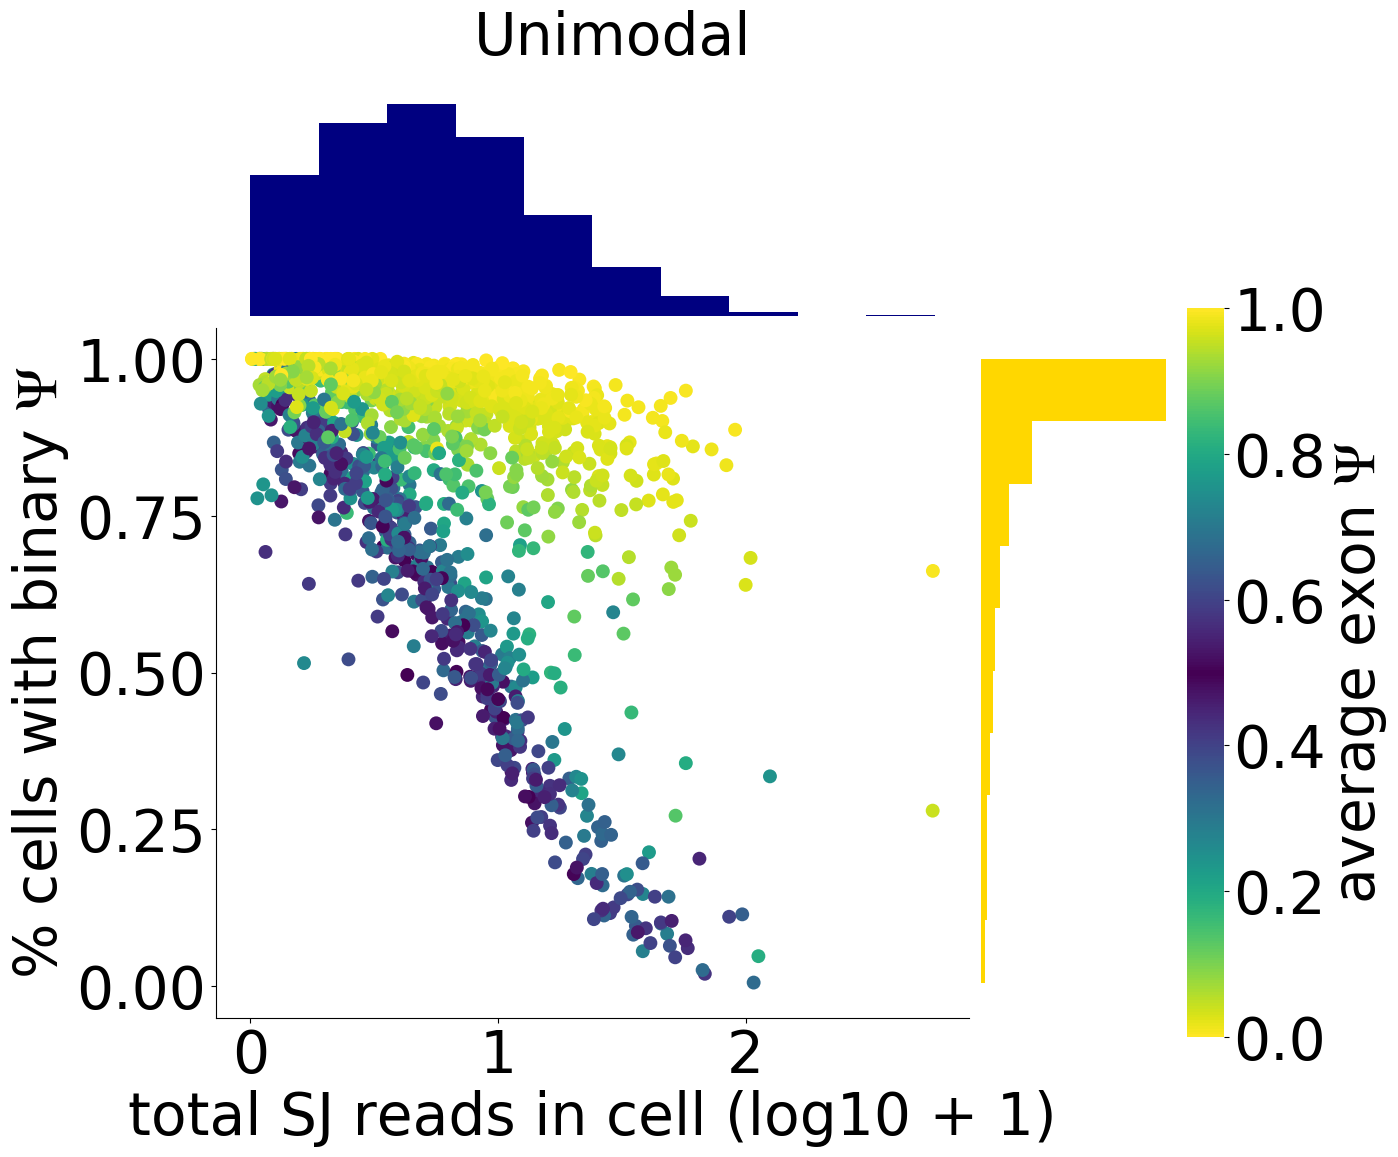

In [17]:
import importlib
importlib.reload(scp)

scp.plot_ase_expression_v_binary(uni_1_psi, uni_1_counts, 'Unimodal', 'simulated_data', 
                              plot_dir = 'plots/sim7/', just_show=False)




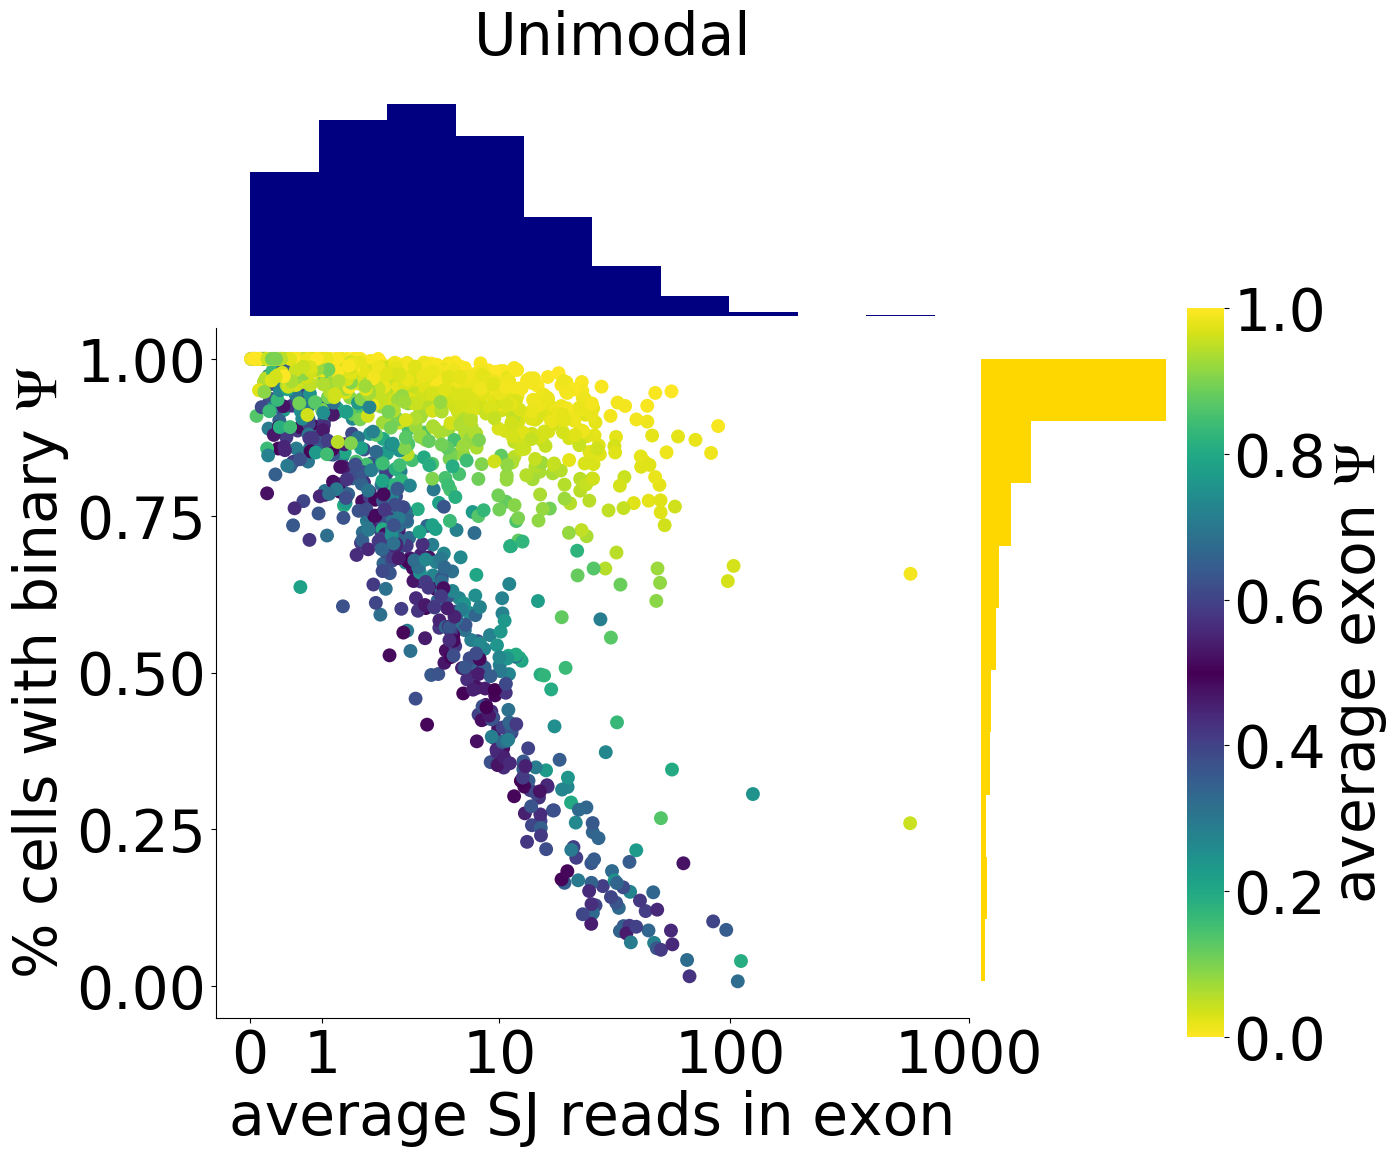

In [7]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

figsize(13, 12)

xlocations=[0, 1, 10, 100, 1000]
#xtags = ['25', '50', '100', '200', '400', '800']
scp.plot_ase_expression_v_binary(uni_1_psi, uni_1_counts, 'Unimodal', 'unimodal_simulation', xlocations=xlocations,
                                 xlabel='average SJ reads in exon',
                              plot_dir = 'plots/sim7/', just_show=False)

plt.show()

In [8]:
bim_true_counts, bim_true_psi = process_symsim('sim7/bimodal_true.tab')
bim_1_counts, bim_1_psi = process_symsim3('sim7/bimodal_observed_1.tab', gene_len)
bim_05_counts, bim_05_psi = process_symsim3('sim7/bimodal_observed_05.tab', gene_len)
bim_02_counts, bim_02_psi = process_symsim3('sim7/bimodal_observed_02.tab', gene_len)
bim_01_counts, bim_01_psi = process_symsim3('sim7/bimodal_observed_01.tab', gene_len)

In [9]:
sort_bim_expression = bim_true_counts.mean(axis=1).sort_values().index
bins_bim_true = scp.get_bins_table(bim_true_psi, bim_true_counts)
bins_bim_1 = scp.get_bins_table(bim_1_psi, bim_true_counts)
bins_bim_05 = scp.get_bins_table(bim_05_psi, bim_true_counts)
bins_bim_02 = scp.get_bins_table(bim_02_psi, bim_true_counts)
bins_bim_01 = scp.get_bins_table(bim_01_psi, bim_true_counts)

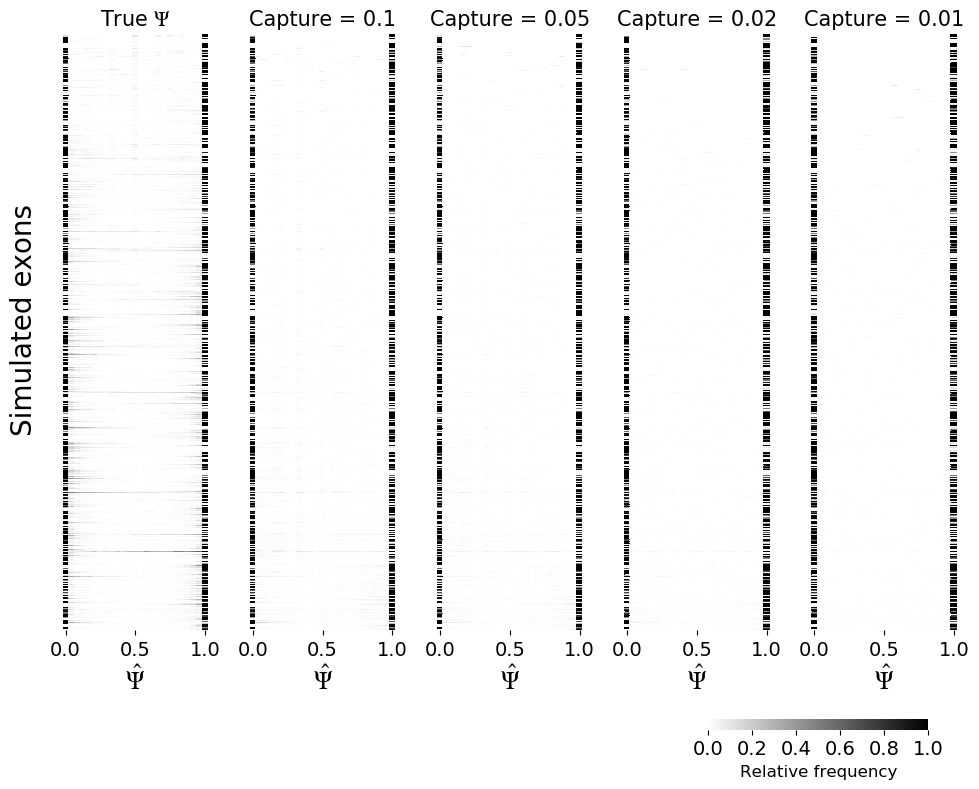

In [14]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
hist_list = [bins_bim_true[0], bins_bim_1[0], bins_bim_05[0], bins_bim_02[0], bins_bim_01[0]]
dset_name_list = ["True $\Psi$", "Capture = 0.1", "Capture = 0.05", "Capture = 0.02", "Capture = 0.01"]

scp.plot_histograms(hist_list, dset_name_list, fig_len=10, fig_height = 10, ypos1=0.025, ypos2 = 0.625,
                    plot_dir = 'plots/sim7/', plot_name = 'sim7_bimodal',
                    plot_title = "", 
                    ylab='Simulated exons', ls=12, sk=1.65, tfs=14, name_size=15)

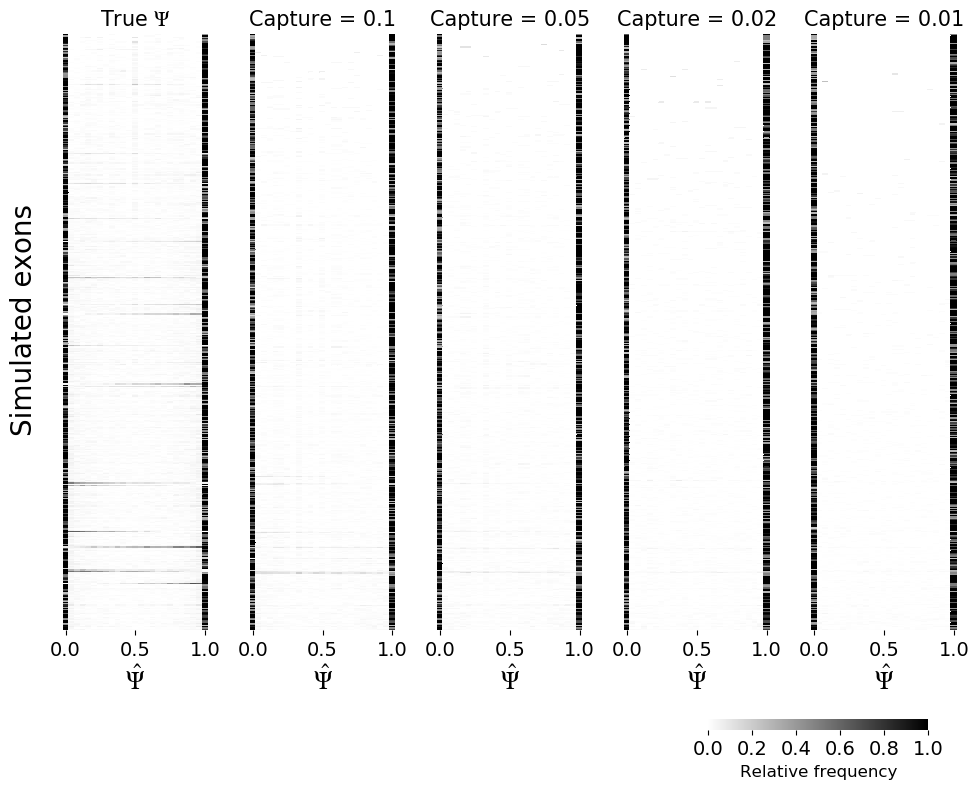

In [15]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
hist_list = [bins_bim_true[1], bins_bim_1[1], bins_bim_05[1], bins_bim_02[1], bins_bim_01[1]]
dset_name_list = ["True $\Psi$", "Capture = 0.1", "Capture = 0.05", "Capture = 0.02", "Capture = 0.01"]

scp.plot_histograms(hist_list, dset_name_list, fig_len=10, fig_height = 10, ypos1=0.025, ypos2 = 0.625,
                    plot_dir = 'plots/sim7/', plot_name = 'sim7_bimodal_intermediate',
                    plot_title = "", 
                    ylab='Simulated exons', ls=12, sk=1.65, tfs=14, name_size=15)

-0.6859069896613839

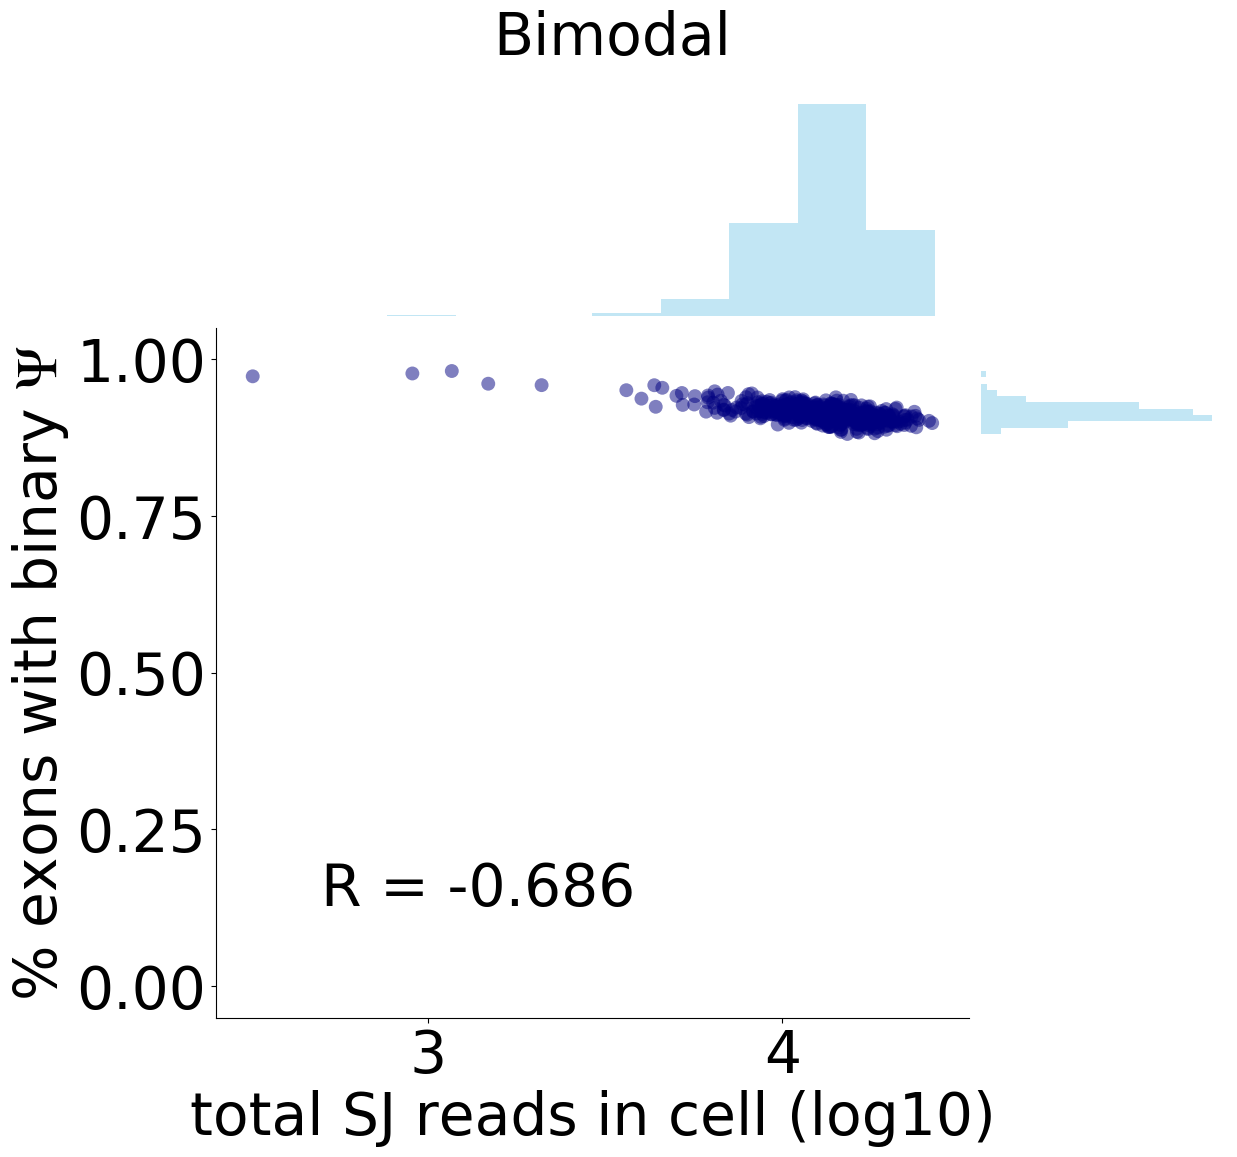

In [22]:
figsize(13,12)
scp.plot_cell_expression_v_binary(bim_1_psi, bim_1_counts, 'Bimodal', 'simulated_bimodal_data', 
                               plot_dir = 'plots/sim7/', just_show=False)


-0.4242968871976897

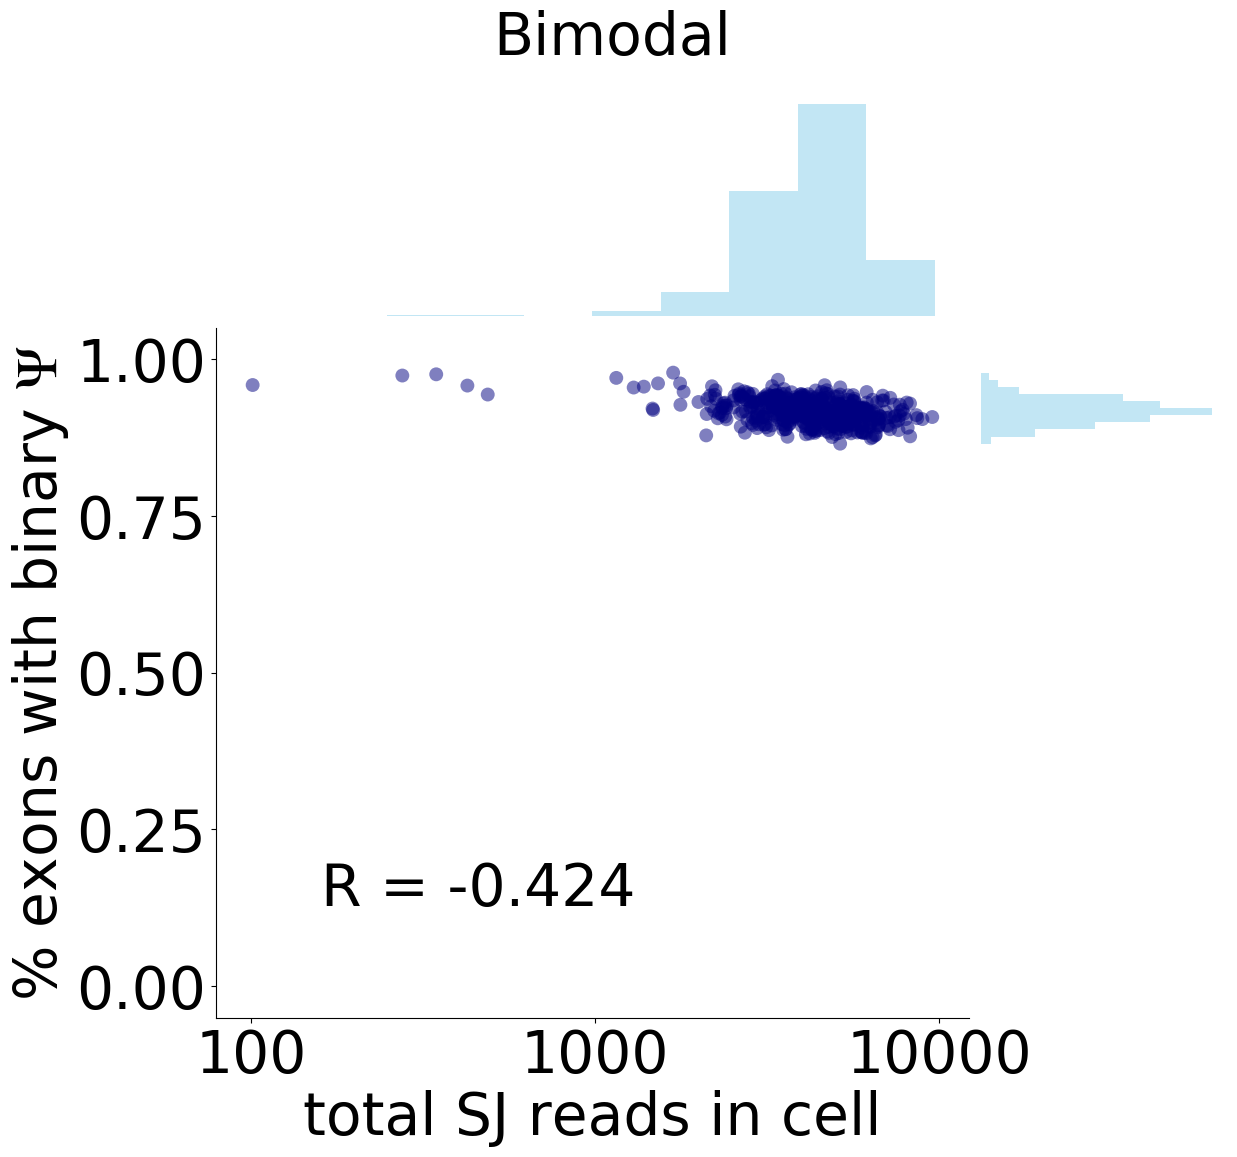

In [23]:
inter = uni_1_psi.loc[(bim_1_psi.mean(axis=1) >= 0.2) & (bim_1_psi.mean(axis=1) <= 0.8)].index
xlocations=[100, 1000, 10000]
#xtags = ['0.1', '1', '10']
scp.plot_cell_expression_v_binary(bim_1_psi.loc[inter], bim_1_counts.loc[inter], 'Bimodal', 'simulated_bimodal_data_intermediate', 
                              xlocations = xlocations, xlabel='total SJ reads in cell',
                                  plot_dir = 'plots/sim7/', just_show=False)

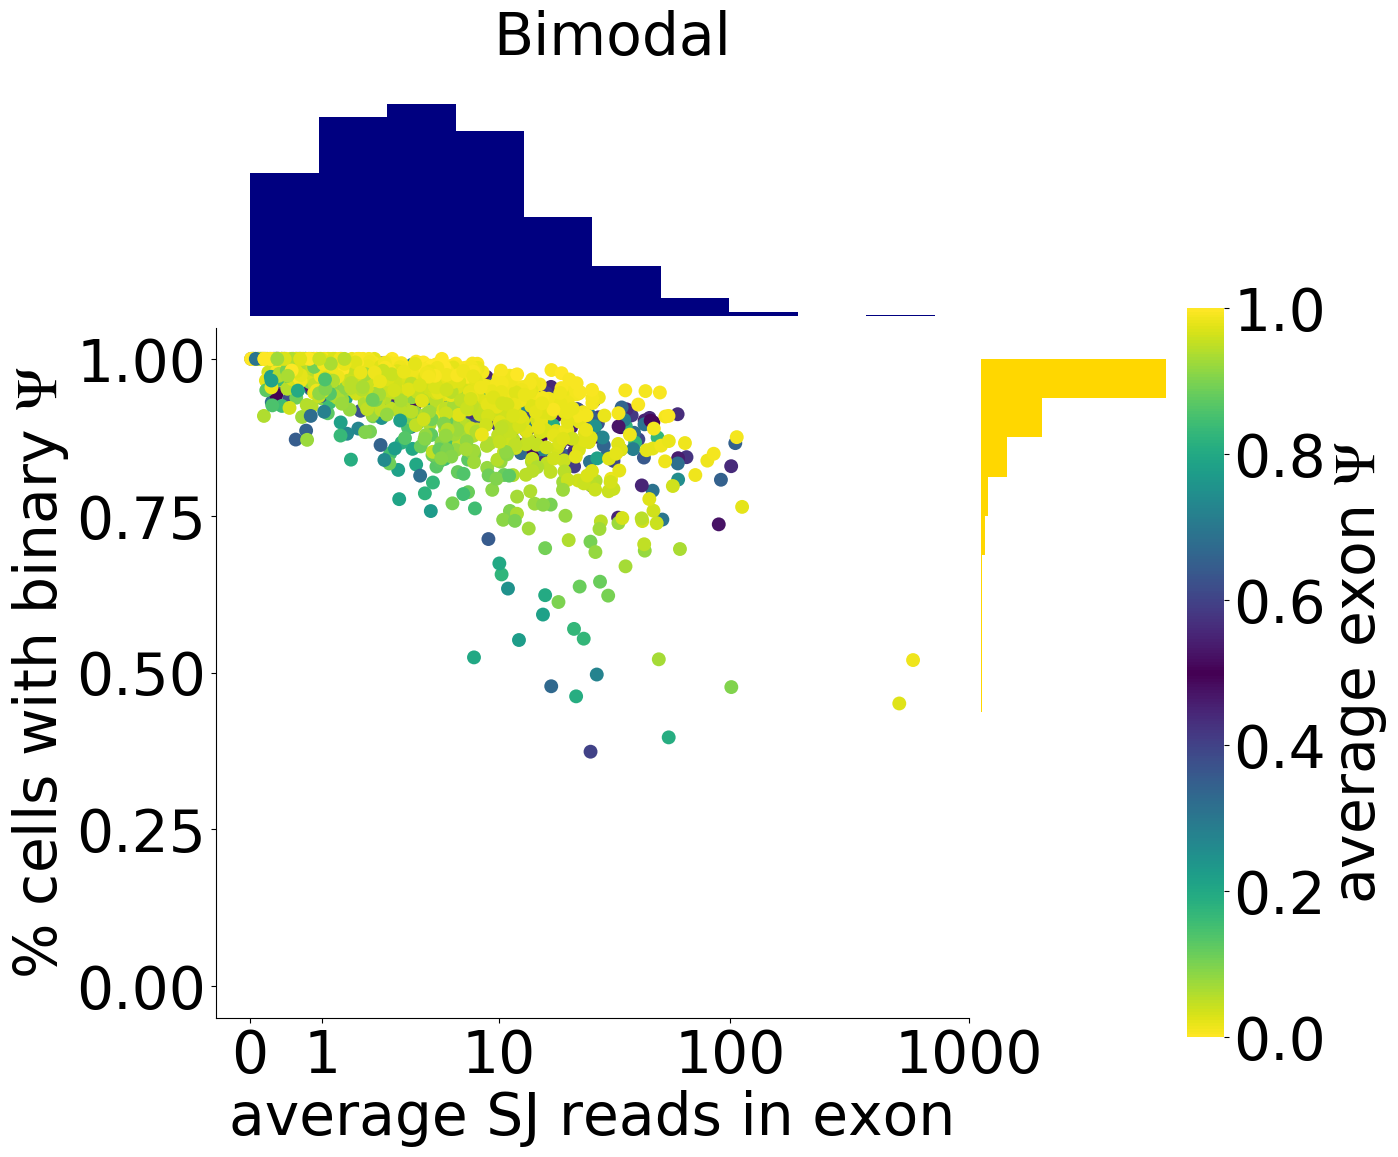

In [10]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

figsize(13, 12)

xlocations=[0, 1, 10, 100, 1000]
#xtags = ['25', '50', '100', '200', '400', '800']
scp.plot_ase_expression_v_binary(bim_1_psi, bim_1_counts, 'Bimodal', 'bimodal_simulation', xlocations=xlocations,
                                 xlabel='average SJ reads in exon',
                              plot_dir = 'plots/sim7/', just_show=False)

plt.show()

-0.6468013167058053

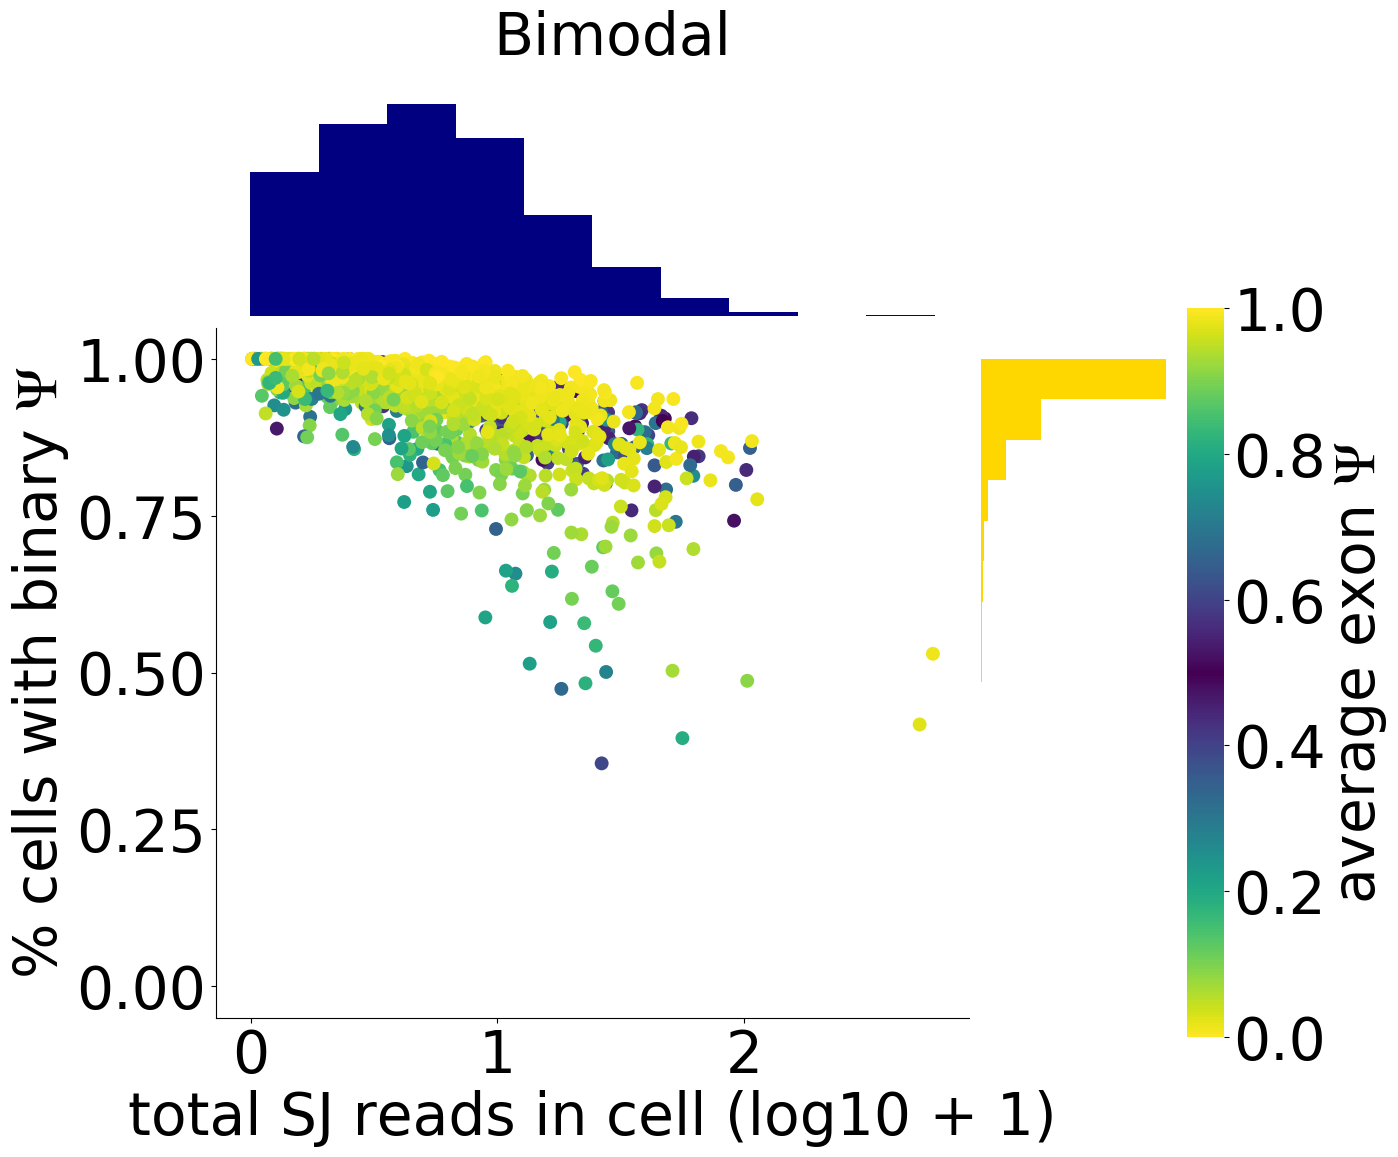

In [25]:
scp.plot_ase_expression_v_binary(bim_1_psi, bim_1_counts, 'Bimodal', 'simulated_data', 
                              plot_dir = 'plots/sim7/', just_show=False)

In [9]:
gene_len = np.array([int(x.rstrip()) for x in open('sim7/gene_length.txt').readlines()])

uni_true_counts, uni_true_psi = process_symsim('sim7/unimodal_true.tab')
uni_1_counts, uni_1_psi = process_symsim3('sim7/unimodal_observed_1.tab', gene_len)
uni_05_counts, uni_05_psi = process_symsim3('sim7/unimodal_observed_05.tab', gene_len)
uni_02_counts, uni_02_psi = process_symsim3('sim7/unimodal_observed_02.tab', gene_len)
uni_01_counts, uni_01_psi = process_symsim3('sim7/unimodal_observed_01.tab', gene_len)

sort_uni_expression = uni_true_counts.mean(axis=1).sort_values().index
bins_uni_true = scp.get_bins_table(uni_true_psi, uni_true_counts)

uni_1_best_counts, uni_1_best_psi = spu.best_cells(uni_1_counts, uni_1_psi)
uni_05_best_counts, uni_05_best_psi = spu.best_cells(uni_05_counts, uni_05_psi)
uni_02_best_counts, uni_02_best_psi = spu.best_cells(uni_02_counts, uni_02_psi)
uni_01_best_counts, uni_01_best_psi = spu.best_cells(uni_01_counts, uni_01_psi)



In [10]:
uni_1_best_complete, uni_1_best_intermediate = scp.get_bins_table(uni_1_best_psi.T, uni_1_best_counts.T)
uni_05_best_complete, uni_05_best_intermediate = scp.get_bins_table(uni_05_best_psi.T, uni_05_best_counts.T)
uni_02_best_complete, uni_02_best_intermediate = scp.get_bins_table(uni_02_best_psi.T, uni_02_best_counts.T)
uni_01_best_complete, uni_01_best_intermediate = scp.get_bins_table(uni_01_best_psi.T, uni_01_best_counts.T)

In [11]:
uni_1_best_complete, uni_1_best_intermediate = scp.get_bins_table(uni_1_best_psi.T, uni_true_counts)
uni_05_best_complete, uni_05_best_intermediate = scp.get_bins_table(uni_05_best_psi.T, uni_true_counts)
uni_02_best_complete, uni_02_best_intermediate = scp.get_bins_table(uni_02_best_psi.T, uni_true_counts)
uni_01_best_complete, uni_01_best_intermediate = scp.get_bins_table(uni_01_best_psi.T, uni_true_counts)

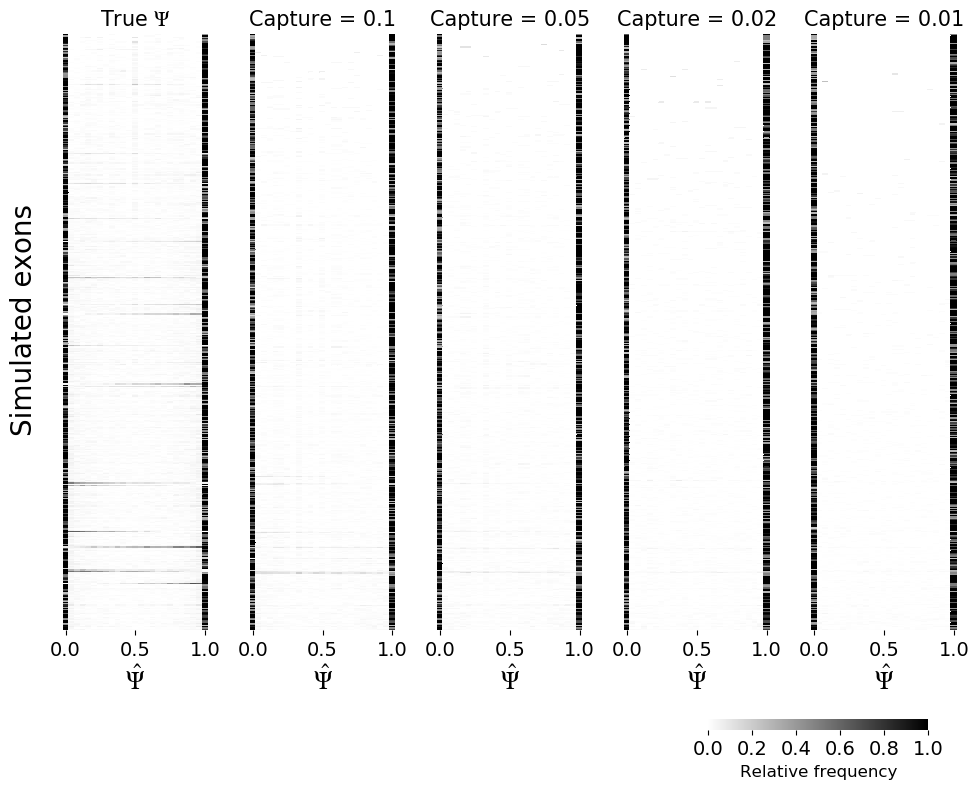

In [22]:
hist_list = [bins_uni_true[1], uni_1_best_intermediate, uni_05_best_intermediate, uni_02_best_intermediate, 
             uni_01_best_intermediate]

dset_name_list = ['True', 'Capture 0.1', 'Capture 0.05', 'Capture 0.02', 'Capture 0.01']

import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"
hist_list = [bins_bim_true[1], bins_bim_1[1], bins_bim_05[1], bins_bim_02[1], bins_bim_01[1]]
dset_name_list = ["True $\Psi$", "Capture = 0.1", "Capture = 0.05", "Capture = 0.02", "Capture = 0.01"]

scp.plot_histograms(hist_list, dset_name_list, fig_len=10, fig_height = 10, ypos1=0.025, ypos2 = 0.625,
                    plot_dir = 'plots/sim7/', plot_name = 'sim7_unimodal_topCells',
                    plot_title = "", 
                    ylab='Simulated exons', ls=12, sk=1.65, tfs=14, name_size=15)


# scp.plot_histograms(hist_list, dset_name_list,fig_len=15, plot_name = 'sim7_unimodal_topCells', fig_ancho=15,
#                 plot_title = 'Unimodal simulations, top cells', ylab='Intermediate exons ranked by expression')

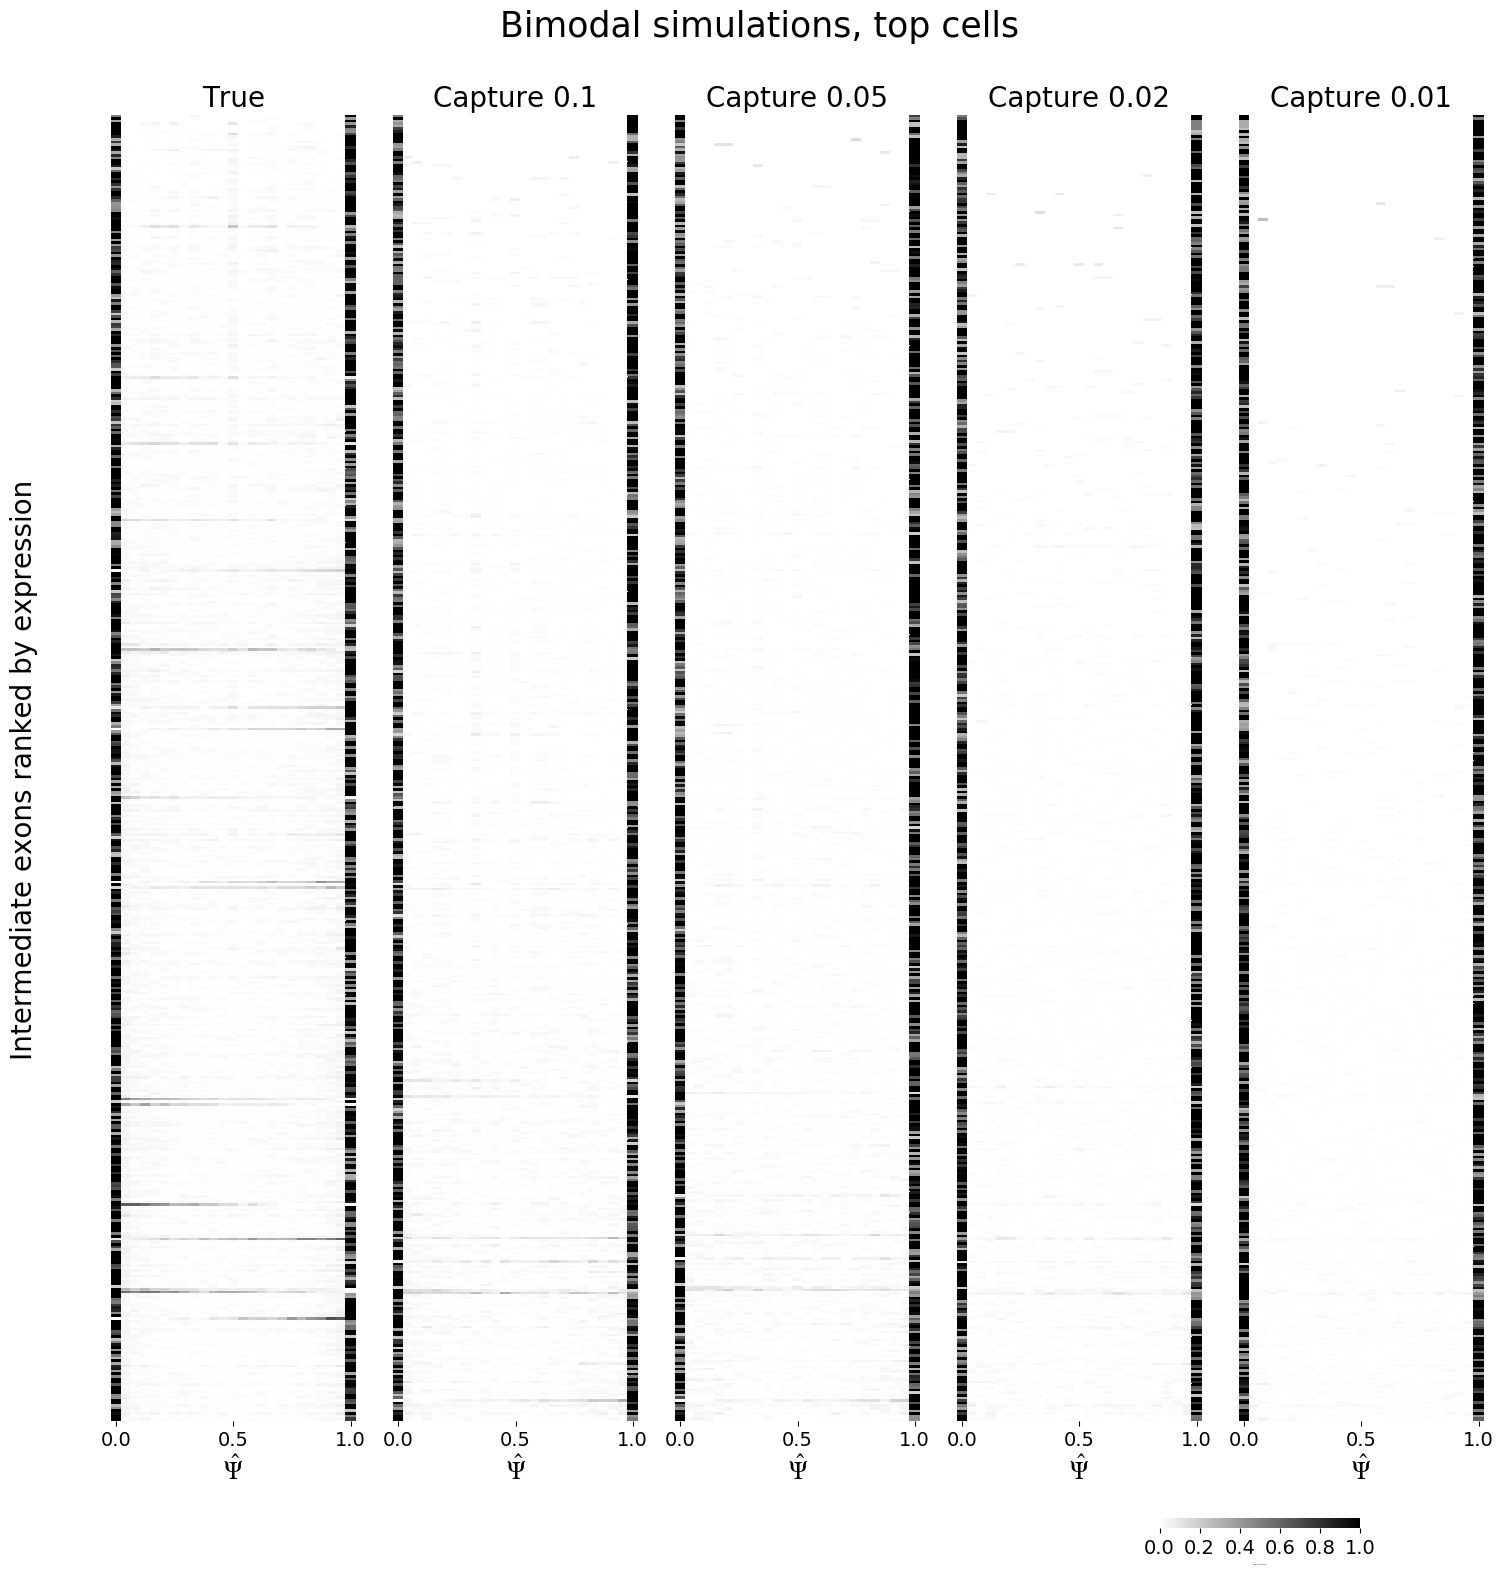

In [23]:
bim_1_best_counts, bim_1_best_psi = spu.best_cells(bim_1_counts, bim_1_psi)
bim_05_best_counts, bim_05_best_psi = spu.best_cells(bim_05_counts, bim_05_psi)
bim_02_best_counts, bim_02_best_psi = spu.best_cells(bim_02_counts, bim_02_psi)
bim_01_best_counts, bim_01_best_psi = spu.best_cells(bim_01_counts, bim_01_psi)

bim_1_best_complete, bim_1_best_intermediate = scp.get_bins_table(bim_1_best_psi.T, bim_true_counts)
bim_05_best_complete, bim_05_best_intermediate = scp.get_bins_table(bim_05_best_psi.T, bim_true_counts)
bim_02_best_complete, bim_02_best_intermediate = scp.get_bins_table(bim_02_best_psi.T, bim_true_counts)
bim_01_best_complete, bim_01_best_intermediate = scp.get_bins_table(bim_01_best_psi.T, bim_true_counts)

hist_list = [bins_bim_true[1], bim_1_best_intermediate, bim_05_best_intermediate, bim_02_best_intermediate, 
             bim_01_best_intermediate]

dset_name_list = ['True', 'Capture 0.1', 'Capture 0.05', 'Capture 0.02', 'Capture 0.01']


plot_histograms(hist_list, dset_name_list,fig_len=15, plot_name = 'sim7_bimodal_topCells', 
                plot_title = 'Bimodal simulations, top cells', ylab='Intermediate exons ranked by expression')

In [12]:
bim_1_best_counts, bim_1_best_psi = spu.best_cells(bim_1_counts, bim_1_psi)
bim_05_best_counts, bim_05_best_psi = spu.best_cells(bim_05_counts, bim_05_psi)
bim_02_best_counts, bim_02_best_psi = spu.best_cells(bim_02_counts, bim_02_psi)
bim_01_best_counts, bim_01_best_psi = spu.best_cells(bim_01_counts, bim_01_psi)

bim_1_best_complete, bim_1_best_intermediate = scp.get_bins_table(bim_1_best_psi.T, bim_true_counts)
bim_05_best_complete, bim_05_best_intermediate = scp.get_bins_table(bim_05_best_psi.T, bim_true_counts)
bim_02_best_complete, bim_02_best_intermediate = scp.get_bins_table(bim_02_best_psi.T, bim_true_counts)
bim_01_best_complete, bim_01_best_intermediate = scp.get_bins_table(bim_01_best_psi.T, bim_true_counts)

hist_list = [bins_bim_true[1], bim_1_best_intermediate, bim_05_best_intermediate, bim_02_best_intermediate, 
             bim_01_best_intermediate]

dset_name_list = ['True', 'Capture 0.1', 'Capture 0.05', 'Capture 0.02', 'Capture 0.01']


/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cfbuenabadn/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


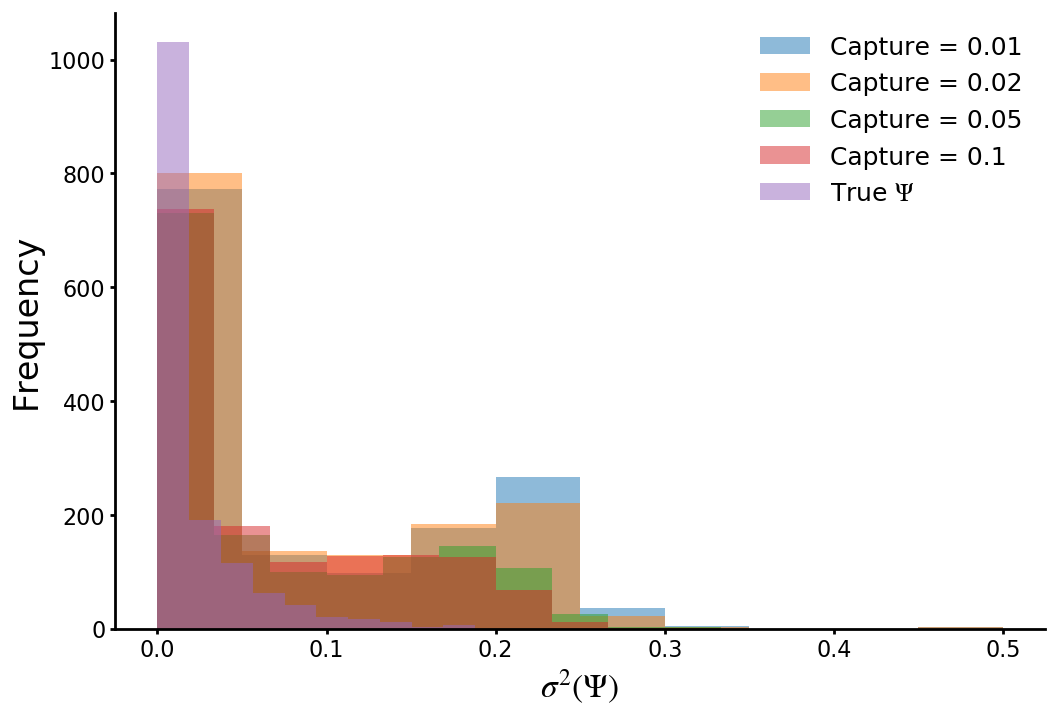

In [13]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(12,8))

ax  = plt.subplot(1,1,1)


# a=np.random.random(100)*0.5 #a uniform distribution
# b=1-np.random.normal(size=100)*0.1 #a normal distribution 
# bins=np.histogram(np.hstack((a,b)), bins=40)[1] #get the bin edges

# plt.hist(a, bins)
# plt.hist(b, bins)

# plt.hist(uni_01_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.01', bins=20, range=(0,0.5))
# plt.hist(uni_02_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.02', bins=20, range=(0,0.5))
# plt.hist(uni_05_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.05', bins=20, range=(0,0.5))
# plt.hist(uni_1_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.1', bins=20, range=(0,0.5))
# plt.hist(uni_true_psi.var(axis=1), alpha=0.5, label='True $\Psi$', bins=20, range=(0,0.5))

plt.hist(uni_01_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.01', range=(0,np.max(uni_01_psi.var(axis=1))))
plt.hist(uni_02_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.02', range=(0,np.max(uni_02_psi.var(axis=1))))
plt.hist(uni_05_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.05', range=(0,np.max(uni_05_psi.var(axis=1))))
plt.hist(uni_1_psi.var(axis=1), alpha=0.5, label = 'Capture = 0.1', range=(0,np.max(uni_1_psi.var(axis=1))))
plt.hist(uni_true_psi.var(axis=1), alpha=0.5, label='True $\Psi$', range=(0,np.max(uni_true_psi.var(axis=1))))


plt.legend(frameon=False,  prop={'size': 18})

plt.xlabel('$\sigma^2(\Psi)$', fontsize=24)
plt.ylabel('Frequency', fontsize=24)

ax.tick_params(labelsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance.png')

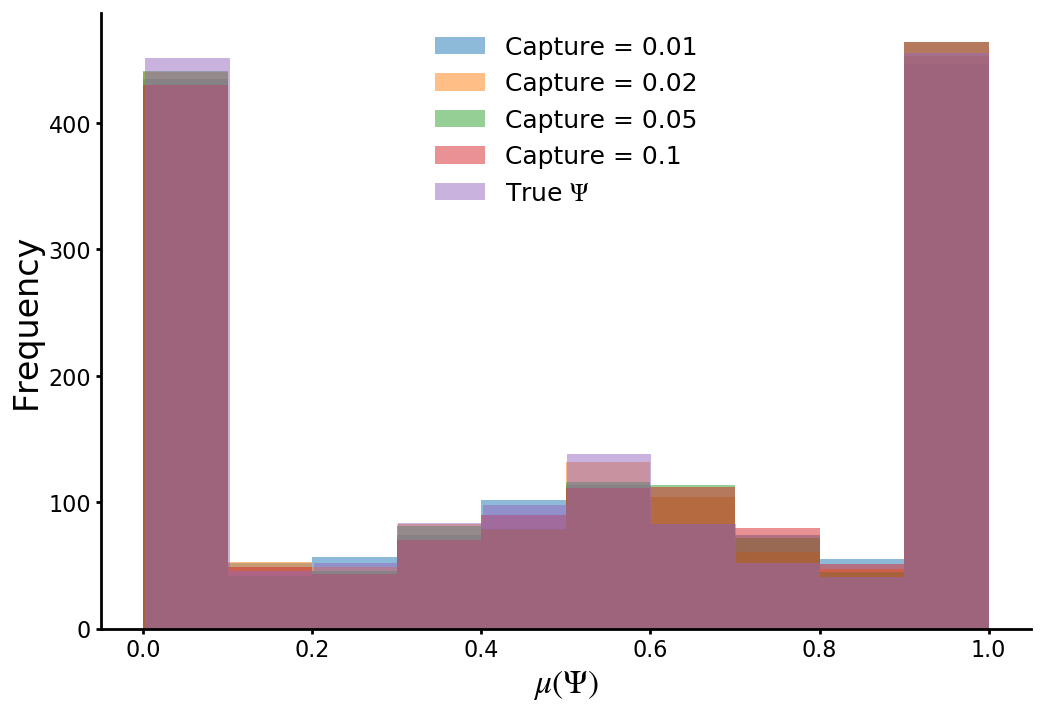

In [14]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(12,8))

ax  = plt.subplot(1,1,1)

plt.hist(uni_01_psi.mean(axis=1).dropna(), alpha=0.5, label = 'Capture = 0.01')
plt.hist(uni_02_psi.mean(axis=1).dropna(), alpha=0.5, label = 'Capture = 0.02')
plt.hist(uni_05_psi.mean(axis=1).dropna(), alpha=0.5, label = 'Capture = 0.05')
plt.hist(uni_1_psi.mean(axis=1).dropna(), alpha=0.5, label = 'Capture = 0.1')
plt.hist(uni_true_psi.mean(axis=1).dropna(), alpha=0.5, label='True $\Psi$')


plt.legend(frameon=False,  prop={'size': 18})

plt.xlabel('$\mu(\Psi)$', fontsize=24)
plt.ylabel('Frequency', fontsize=24)


ax.tick_params(labelsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)


plt.savefig('plots/sim7/sim7_beta_unif_unimodal_mean.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_mean.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_mean.png')

In [15]:
uni_1_psi_int = uni_1_psi.loc[(uni_1_psi.mean(axis=1) >= 0.2) & (uni_1_psi.mean(axis=1) <= 0.8)]
uni_05_psi_int = uni_05_psi.loc[(uni_05_psi.mean(axis=1) >= 0.2) & (uni_05_psi.mean(axis=1) <= 0.8)]
uni_02_psi_int = uni_02_psi.loc[(uni_02_psi.mean(axis=1) >= 0.2) & (uni_02_psi.mean(axis=1) <= 0.8)]
uni_01_psi_int = uni_01_psi.loc[(uni_01_psi.mean(axis=1) >= 0.2) & (uni_01_psi.mean(axis=1) <= 0.8)]

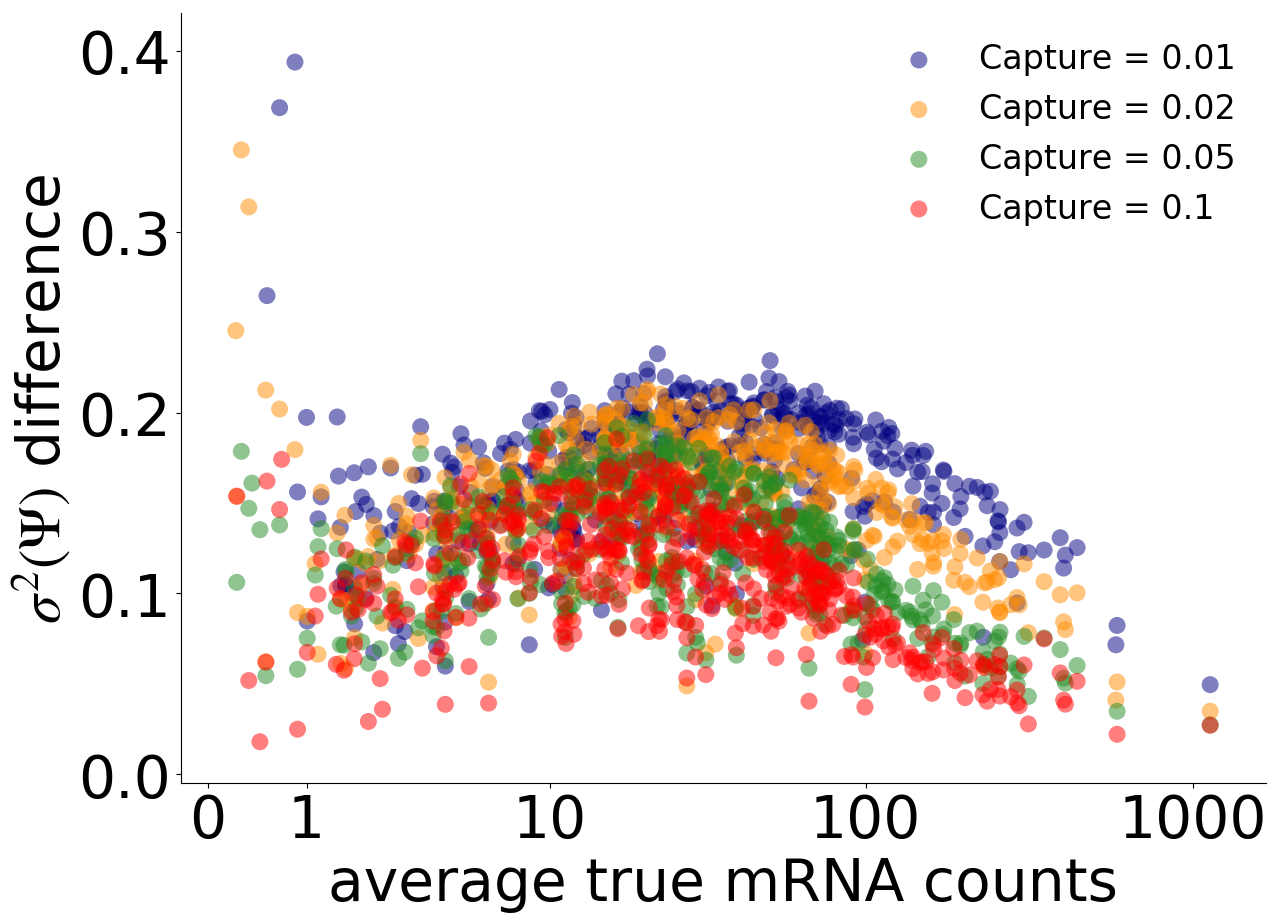

In [16]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(14,10))

ax  = plt.subplot(1,1,1)



plt.scatter(np.log10(uni_true_counts.loc[uni_01_psi_int.index].mean(axis=1)+1),
    (np.abs(uni_01_psi_int.var(axis=1) - uni_true_psi.loc[uni_01_psi_int.index].var(axis=1))), 
            c='navy', alpha=0.5, label = 'Capture = 0.01', s=150, edgecolors='none')

plt.scatter(np.log10(uni_true_counts.loc[uni_02_psi_int.index].mean(axis=1)+1),
    (np.abs(uni_02_psi_int.var(axis=1) - uni_true_psi.loc[uni_02_psi_int.index].var(axis=1))), 
            c='darkorange', alpha=0.5, label = 'Capture = 0.02', s=150, edgecolors='none')

plt.scatter(np.log10(uni_true_counts.loc[uni_05_psi_int.index].mean(axis=1)+1),
    (np.abs(uni_05_psi_int.var(axis=1) - uni_true_psi.loc[uni_05_psi_int.index].var(axis=1))), 
            c='forestgreen', alpha=0.5, label = 'Capture = 0.05', s=150, edgecolors='none')

plt.scatter(np.log10(uni_true_counts.loc[uni_1_psi_int.index].mean(axis=1)+1), 
            (np.abs(uni_1_psi_int.var(axis=1) - uni_true_psi.loc[uni_1_psi_int.index].var(axis=1))), 
            c='red', alpha=0.5, label = 'Capture = 0.1', s=150, edgecolors='none')



plt.xlabel('average true mRNA counts', fontsize=42)
plt.ylabel('$\sigma^2(\Psi)$ difference', fontsize=42)

plt.legend(frameon=False,  prop={'size': 24})

ax.tick_params(labelsize=42)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

# ax.xaxis.set_tick_params(width=2)
# ax.yaxis.set_tick_params(width=2)

xlocations = [0, 1, 10, 100, 1000]
xlocs = np.array([np.log10(x+1) for x in xlocations])
xtags = [str(i) for i in xlocations]
plt.xticks(xlocs, xtags)

plt.savefig('plots/sim7/sim7_beta_unif_unimodal_int_variance_diff.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_int_variance_diff.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_int_variance_diff.png')

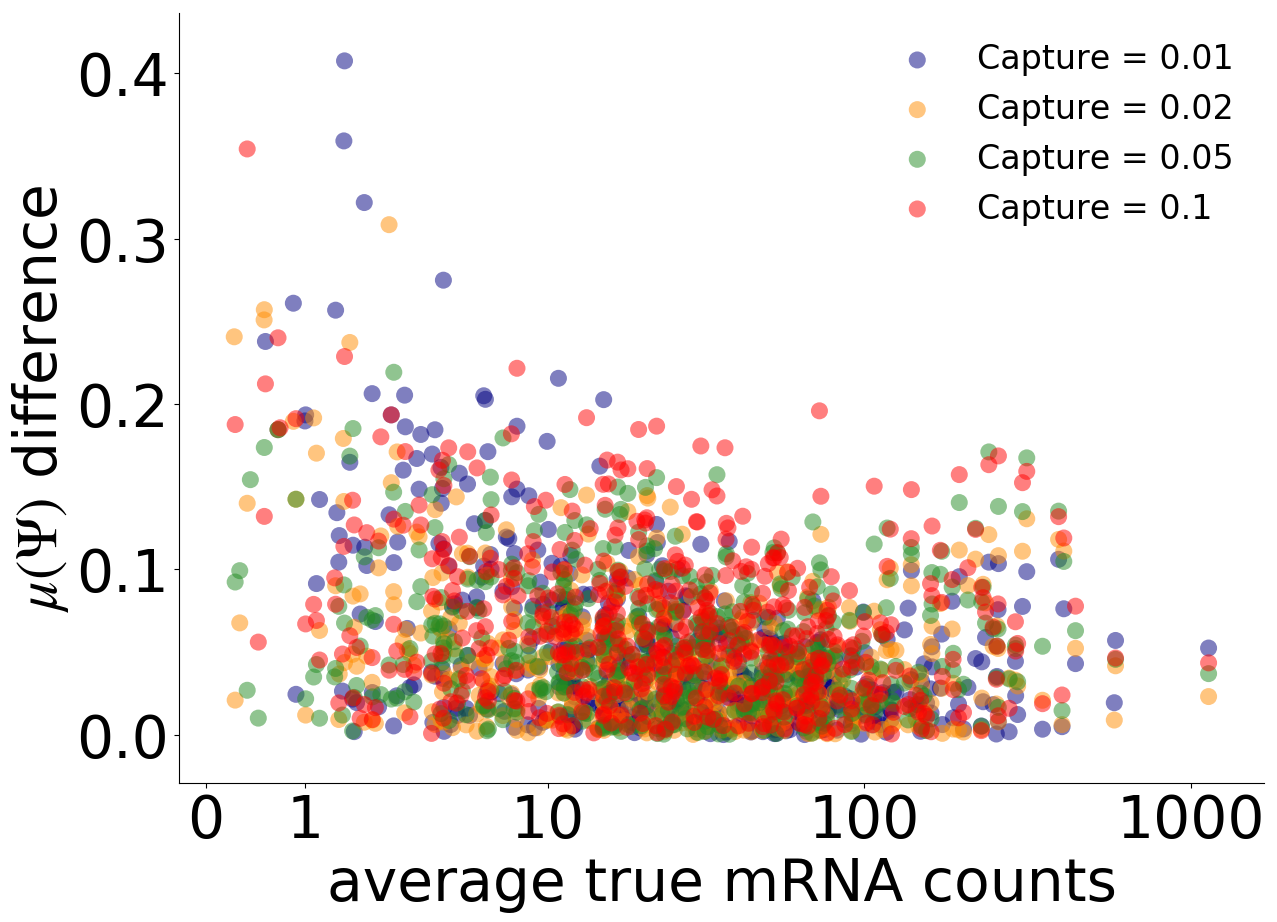

In [17]:
fig = plt.figure(figsize=(14,10))

ax  = plt.subplot(1,1,1)

plt.scatter(np.log10(uni_true_counts.loc[uni_01_psi_int.index].mean(axis=1)+1),
    (np.abs(uni_01_psi_int.mean(axis=1) - uni_true_psi.loc[uni_01_psi_int.index].mean(axis=1))), 
            c='navy', alpha=0.5, label = 'Capture = 0.01', s=150, edgecolors='none')

plt.scatter(np.log10(uni_true_counts.loc[uni_02_psi_int.index].mean(axis=1)+1),
    (np.abs(uni_02_psi_int.mean(axis=1) - uni_true_psi.loc[uni_02_psi_int.index].mean(axis=1))), 
            c='darkorange', alpha=0.5, label = 'Capture = 0.02', s=150, edgecolors='none')

plt.scatter(np.log10(uni_true_counts.loc[uni_05_psi_int.index].mean(axis=1)+1),
    (np.abs(uni_05_psi_int.mean(axis=1) - uni_true_psi.loc[uni_05_psi_int.index].mean(axis=1))), 
            c='forestgreen', alpha=0.5, label = 'Capture = 0.05', s=150, edgecolors='none')

plt.scatter(np.log10(uni_true_counts.loc[uni_1_psi_int.index].mean(axis=1)+1), 
            (np.abs(uni_1_psi_int.mean(axis=1) - uni_true_psi.loc[uni_1_psi_int.index].mean(axis=1))), 
            c='red', alpha=0.5, label = 'Capture = 0.1', s=150, edgecolors='none')


plt.legend(frameon=False,  prop={'size': 24})

ax.tick_params(labelsize=42)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

# ax.xaxis.set_tick_params(width=2)
# ax.yaxis.set_tick_params(width=2)

plt.xlabel('average true mRNA counts', fontsize=42)
plt.ylabel('$\mu(\Psi)$ difference', fontsize=42)

xlocations = [0, 1, 10, 100, 1000]
xlocs = np.array([np.log10(x+1) for x in xlocations])
xtags = [str(i) for i in xlocations]
plt.xticks(xlocs, xtags)


plt.savefig('plots/sim7/sim7_beta_unif_unimodal_int_mean_diff.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_int_mean_diff.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_int_mean_diff.png')

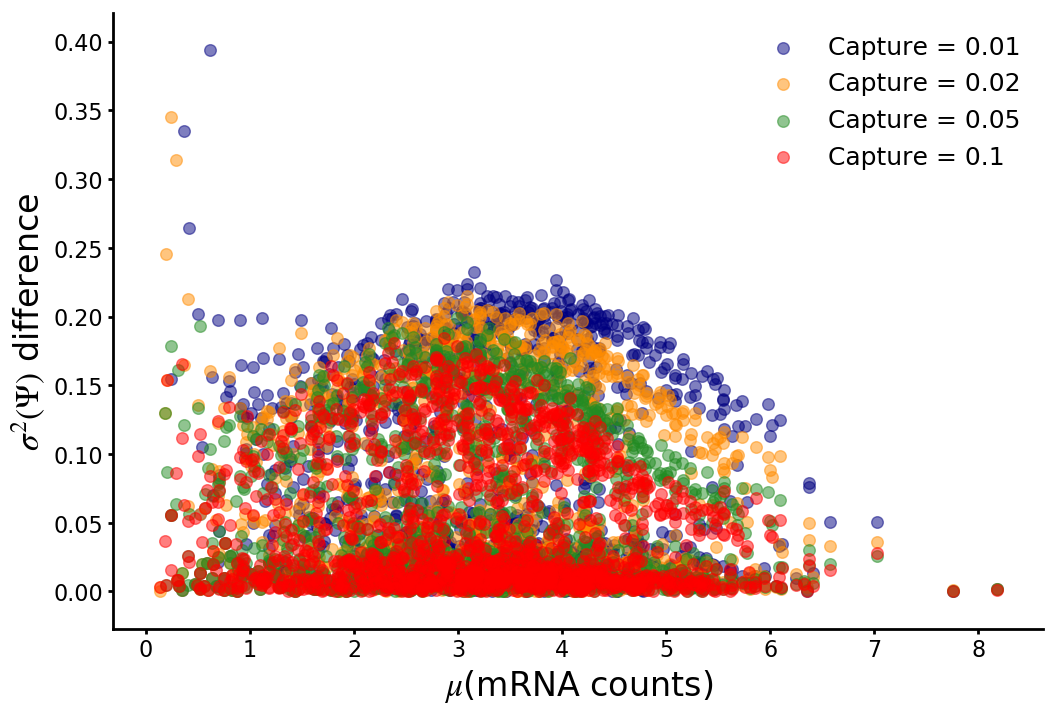

In [24]:
import importlib
importlib.reload(scp)
importlib.reload(spu)
sns.reset_orig()
mpl.rcParams["mathtext.fontset"] = "stix"

fig = plt.figure(figsize=(12,8))

ax  = plt.subplot(1,1,1)



plt.scatter(np.log1p(uni_true_counts.mean(axis=1)),
    (np.abs(uni_01_psi.var(axis=1) - uni_true_psi.var(axis=1))), 
            c='navy', alpha=0.5, label = 'Capture = 0.01', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)),
    (np.abs(uni_02_psi.var(axis=1) - uni_true_psi.var(axis=1))), 
            c='darkorange', alpha=0.5, label = 'Capture = 0.02', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)),
    (np.abs(uni_05_psi.var(axis=1) - uni_true_psi.var(axis=1))), 
            c='forestgreen', alpha=0.5, label = 'Capture = 0.05', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), (np.abs(uni_1_psi.var(axis=1) - uni_true_psi.var(axis=1))), 
            c='red', alpha=0.5, label = 'Capture = 0.1', s=70)



plt.xlabel('$\mu$(mRNA counts)', fontsize=24)
plt.ylabel('$\sigma^2(\Psi)$ difference', fontsize=24)

plt.legend(frameon=False,  prop={'size': 18})

ax.tick_params(labelsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance_diff.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance_diff.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance_diff.png')

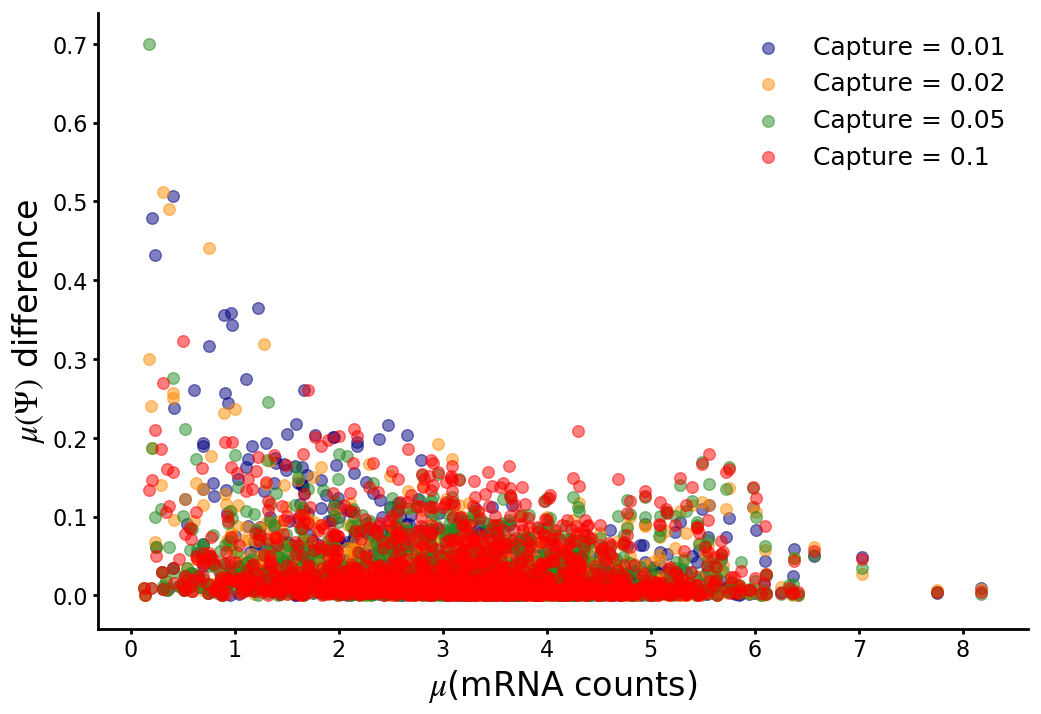

In [25]:
fig = plt.figure(figsize=(12,8))

ax  = plt.subplot(1,1,1)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)),
    (np.abs(uni_01_psi.mean(axis=1) - uni_true_psi.mean(axis=1))), 
            c='navy', alpha=0.5, label = 'Capture = 0.01', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)),
    (np.abs(uni_02_psi.mean(axis=1) - uni_true_psi.mean(axis=1))), 
            c='darkorange', alpha=0.5, label = 'Capture = 0.02', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)),
    (np.abs(uni_05_psi.mean(axis=1) - uni_true_psi.mean(axis=1))), 
            c='forestgreen', alpha=0.5, label = 'Capture = 0.05', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), (np.abs(uni_1_psi.mean(axis=1) - uni_true_psi.mean(axis=1))), 
            c='red', alpha=0.5, label = 'Capture = 0.1', s=70)


plt.legend(frameon=False,  prop={'size': 18})

ax.tick_params(labelsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

plt.xlabel('$\mu$(mRNA counts)', fontsize=24)
plt.ylabel('$\mu(\Psi)$ difference', fontsize=24)


plt.savefig('plots/sim7/sim7_beta_unif_unimodal_mean_diff.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_mean_diff.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_mean_diff.png')

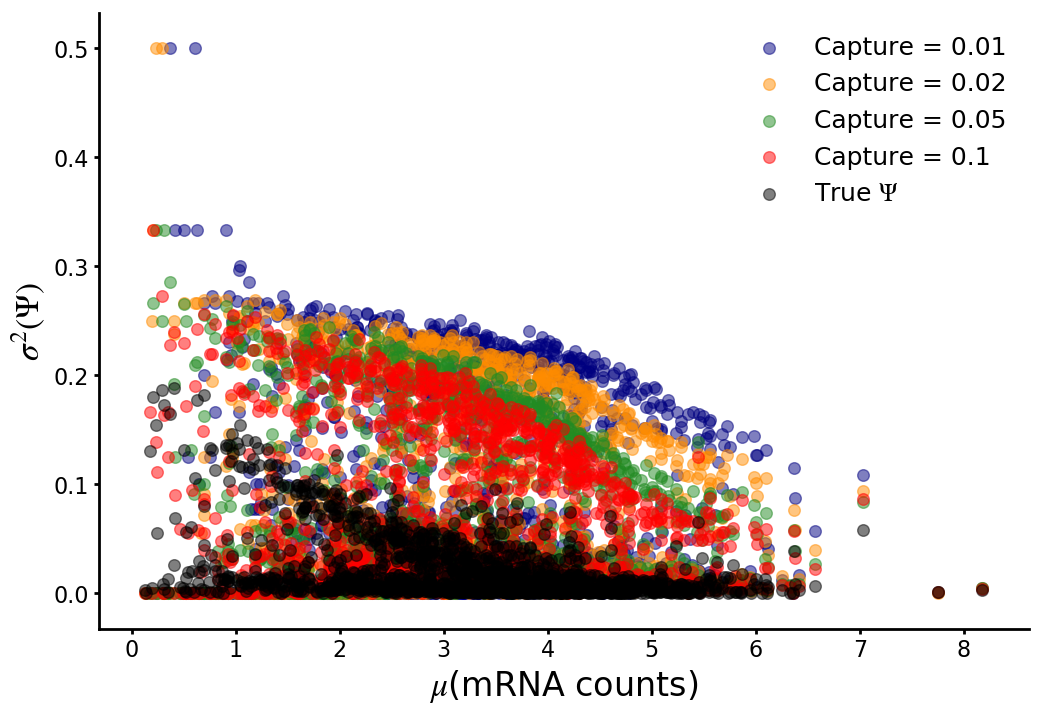

In [26]:
fig = plt.figure(figsize=(12,8))

ax  = plt.subplot(1,1,1)


plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_01_psi.var(axis=1), c='navy', alpha=0.5, label='Capture = 0.01', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_02_psi.var(axis=1), c='darkorange', alpha=0.5, label='Capture = 0.02', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_05_psi.var(axis=1), c='forestgreen', alpha=0.5, label='Capture = 0.05', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_1_psi.var(axis=1), c='red', alpha=0.5, label='Capture = 0.1', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_true_psi.var(axis=1), c='black', alpha=0.5, label='True $\Psi$', s=70)


plt.legend(frameon=False,  prop={'size': 18})

ax.tick_params(labelsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

plt.xlabel('$\mu$(mRNA counts)', fontsize=24)
plt.ylabel('$\sigma^2(\Psi)$', fontsize=24)



plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance_1.svg')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance_1.pdf')
plt.savefig('plots/sim7/sim7_beta_unif_unimodal_variance_1.png')

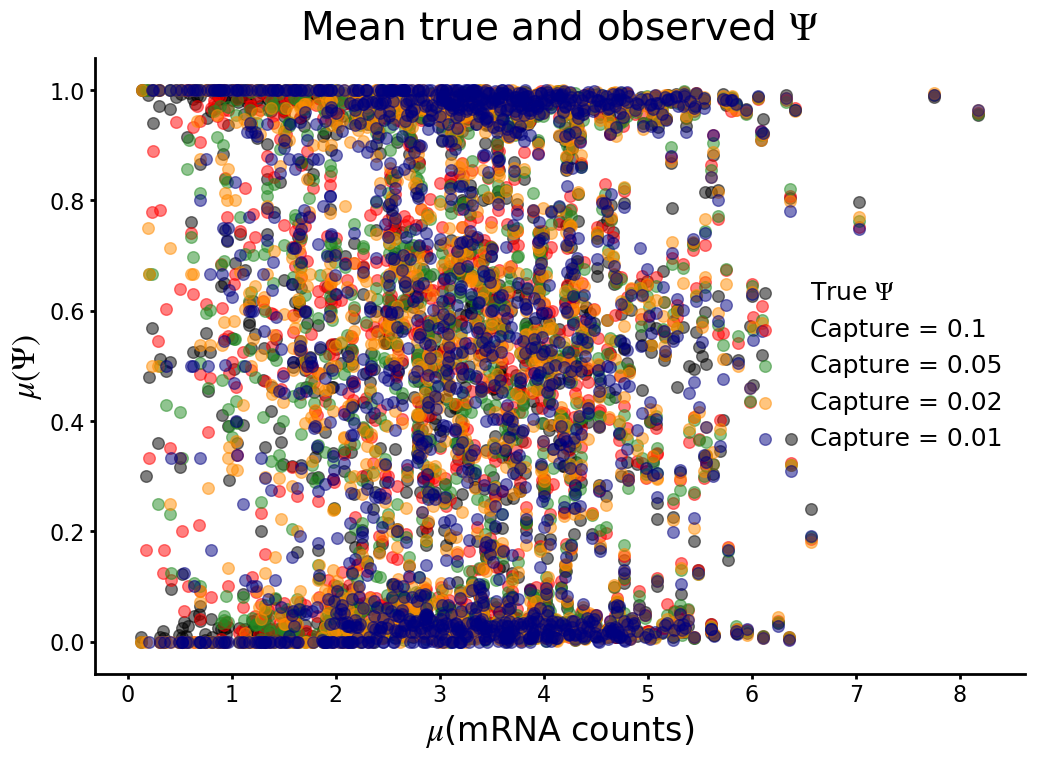

In [27]:
fig = plt.figure(figsize=(12,8))

figure_title = "Mean true and observed $\Psi$"
ax  = plt.subplot(1,1,1)

plt.text(0.5, 1.03, figure_title,
         horizontalalignment='center',
         fontsize=28,
         transform = ax.transAxes)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_true_psi.mean(axis=1), c='black', alpha=0.5, label='True $\Psi$', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_1_psi.mean(axis=1), c='red', alpha=0.5, label='Capture = 0.1', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_05_psi.mean(axis=1), c='forestgreen', alpha=0.5, label='Capture = 0.05', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_02_psi.mean(axis=1), c='darkorange', alpha=0.5, label='Capture = 0.02', s=70)

plt.scatter(np.log1p(uni_true_counts.mean(axis=1)), uni_01_psi.mean(axis=1), c='navy', alpha=0.5, label='Capture = 0.01', s=70)

plt.legend(frameon=False,  prop={'size': 18})

ax.tick_params(labelsize=16)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)

plt.xlabel('$\mu$(mRNA counts)', fontsize=24)
plt.ylabel('$\mu(\Psi)$', fontsize=24)

plt.savefig('plots/sim7_beta_unif_unimodal_mean_1.svg')
plt.savefig('plots/sim7_beta_unif_unimodal_mean_1.pdf')
plt.savefig('plots/sim7_beta_unif_unimodal_mean_1.png')